## **Housing Price Regression**

Name: Ryan Yeo

Admin Number: P2214452

Class: DAAA/FT/2A/01

<hr>

## **Background Research**

#### **Objective**
Use a supervised regression machine learning model to predict the housing price in US

#### **Housing Price Background**

The dataset was collected from a property agent from houses in the United States

The job of the property agent is to try and help others buy or sell their property and the buying/selling price for the properties can be determined using housing prices for other properties with similar features

<hr>

#### **Factors used in predicting housing price**

Some factors that affect the price of housing include:
- Location =>quality of local schools, proximity to shopping and recreational centers etc.
- Home size and usable space => a biiger home can positively impact its valuation
- Age and condition => newer houses are appraised at a higher value
- Updates and Upgrades => Renovations and other upgrades in the house
- Local Market => number of other properties for sale in the area


In [1]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import statsmodels.api as sm

# SKLEARN Libraries

# Model Selection
from sklearn.model_selection import (
    train_test_split,
    cross_validate,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_predict,
    learning_curve,
    KFold,
)

from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from sklearn.tree import export_graphviz
from sklearn.tree import plot_tree

# Pipeline
from imblearn.pipeline import Pipeline

# Models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import ElasticNet
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.svm import SVR



# Preprocessing
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OrdinalEncoder, OneHotEncoder, MinMaxScaler

# Saving models
import pickle


In [2]:
# Set random state
random_state = 42

In [3]:
df = pd.read_csv('housing_dataset.csv')
display(df.head())

,House ID,City,House Area (sqm),No. of Bedrooms,No. of Toilets,Stories,Renovation Status,Price ($)
0,0,Chicago,742.0,4,2,3,furnished,1330000
1,1,Denver,896.0,4,4,4,furnished,1225000
2,2,Chicago,996.0,3,2,2,semi-furnished,1225000
3,3,Seattle,750.0,4,2,2,furnished,1221500
4,4,New York,742.0,4,1,2,furnished,1141000


## 1. EDA

In [4]:
print(list(df.columns))

['House ID', 'City', 'House Area (sqm)', 'No. of Bedrooms', 'No. of Toilets', 'Stories', 'Renovation Status', 'Price ($)']


Rename some of the columns

In [5]:
# Rename columns
df = df.rename(
    columns={
        "House Area (sqm)": "Area",
        "No. of Bedrooms": "Bedroom_count",
        "No. of Toilets": "Toilet_count",
        "Stories": "Storey_count",
        "Renovation Status": "Renovation_status",
        "Price ($)": "Price"
    }
)

In [6]:
print(f"Shape: {df.shape}")
print(df.info())

Shape: (545, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   House ID           545 non-null    int64  
 1   City               545 non-null    object 
 2   Area               545 non-null    float64
 3   Bedroom_count      545 non-null    int64  
 4   Toilet_count       545 non-null    int64  
 5   Storey_count       545 non-null    int64  
 6   Renovation_status  545 non-null    object 
 7   Price              545 non-null    int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 34.2+ KB
None


**Data Dictionary**

| Column Name  | Data Type  | Definition  | 
|---|---|---|
| House ID  | Primary Key  | Unique House identifier ranging from 0 to 544  |
|  City |  Nominal Category | City the house is located at  |
| Area |  Numeric | Size of the house in square meters  |
| Bedroom_count  |  Numeric | Number of bedrooms in the house |
| Toilet_count  | Numeric  | Number of toilets in the house |
| Storey_count  | Numeric  | Number of stories in the house |
| Renovation_status  | Ordinal Category  | How well the house is renovated  |
| Price  | Target Variable  | Price of the house in USD  |

The target variable of the dataset is *Price* which means that the goal is to try and predict the price of the house in USD

In [7]:
# Convert columns to category
df[['City', 'Renovation_status']] = df[['City', 'Renovation_status']].astype('category')

Check all unique values in the categorical features

In [8]:
print(f"City: {list(df['City'].unique())}")
print(f"Renovation Status: {list(df['Renovation_status'].unique())}")

City: ['Chicago', 'Denver', 'Seattle', 'New York', 'Boston']
Renovation Status: ['furnished', 'semi-furnished', 'unfurnished']


In [9]:
print("SUMMARY STATISTICS OF NUMERIC COLUMNS")
display(df.describe().T)

SUMMARY STATISTICS OF NUMERIC COLUMNS


,count,mean,std,min,25%,50%,75%,max
House ID,545.0,272.000000,157.472220,0.0,136.0,272.0,408.0,544.0
Area,545.0,515.054128,217.014102,165.0,360.0,460.0,636.0,1620.0
Bedroom_count,545.0,2.965138,0.738064,1.0,2.0,3.0,3.0,6.0
Toilet_count,545.0,1.286239,0.502470,1.0,1.0,1.0,2.0,4.0
Storey_count,545.0,1.805505,0.867492,1.0,1.0,2.0,2.0,4.0
Price,545.0,476672.924771,187043.961566,175000.0,343000.0,434000.0,574000.0,1330000.0


Check for missing values

In [10]:
print(df.isnull().sum())

House ID             0
City                 0
Area                 0
Bedroom_count        0
Toilet_count         0
Storey_count         0
Renovation_status    0
Price                0
dtype: int64


To prevent the mutation of our original dataset, we will make a copy of it for our EDA

In [11]:
df_eda = df.copy()

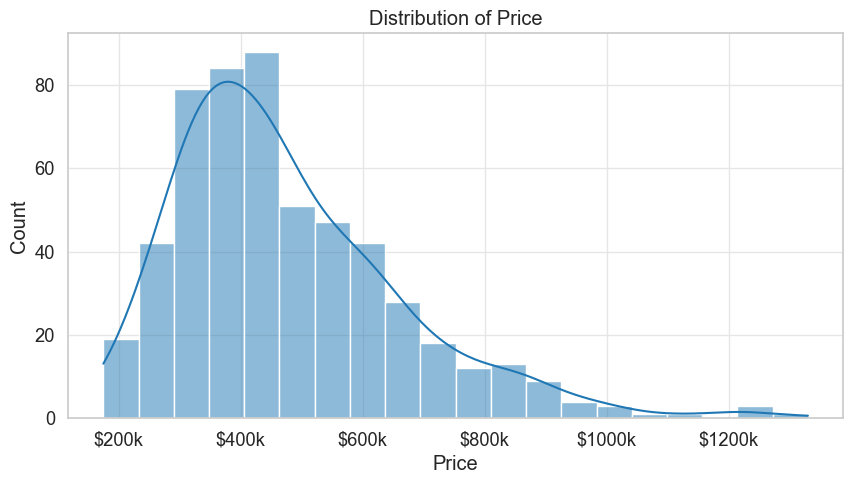

In [12]:
# Check distribution of target variable
sns.set_context('notebook', font_scale=1.2)
sns.set_style('whitegrid', {'grid.color': '0.9'})

fig, ax = plt.subplots(figsize=(10, 5))
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: f'${x/1000:1.0f}k'))

plt.title("Distribution of Price")

sns.histplot(data=df_eda, x="Price", bins=20, ax=ax, kde=True)
plt.show()


**Observations**:
- Price is positively-skewed with a mode of around 375k USD

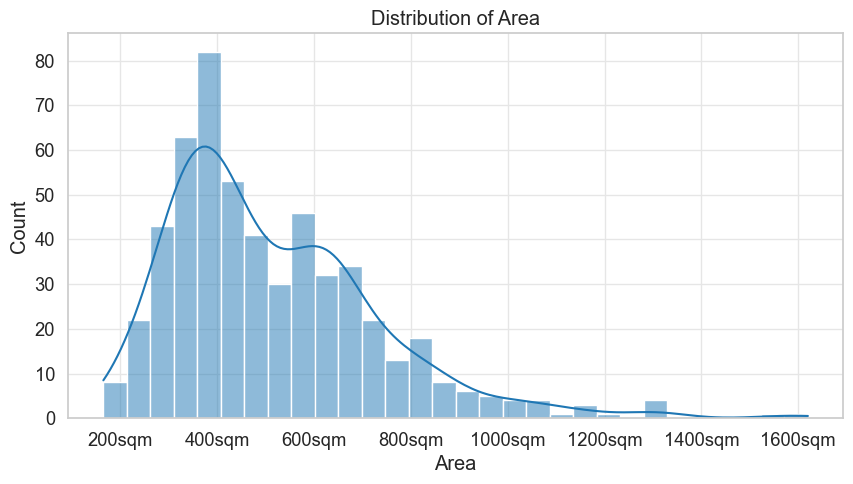

In [13]:
# Check distribution of area
fig, ax = plt.subplots(figsize=(10, 5))
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: f'{x:1.0f}sqm'))

plt.title("Distribution of Area")

sns.histplot(data=df_eda, x="Area", bins=30, ax=ax, kde=True)

plt.show()

**Observations**:
- Area is positively-skewed with a bimodal distribution at around 380 sqm and at 620 sqm

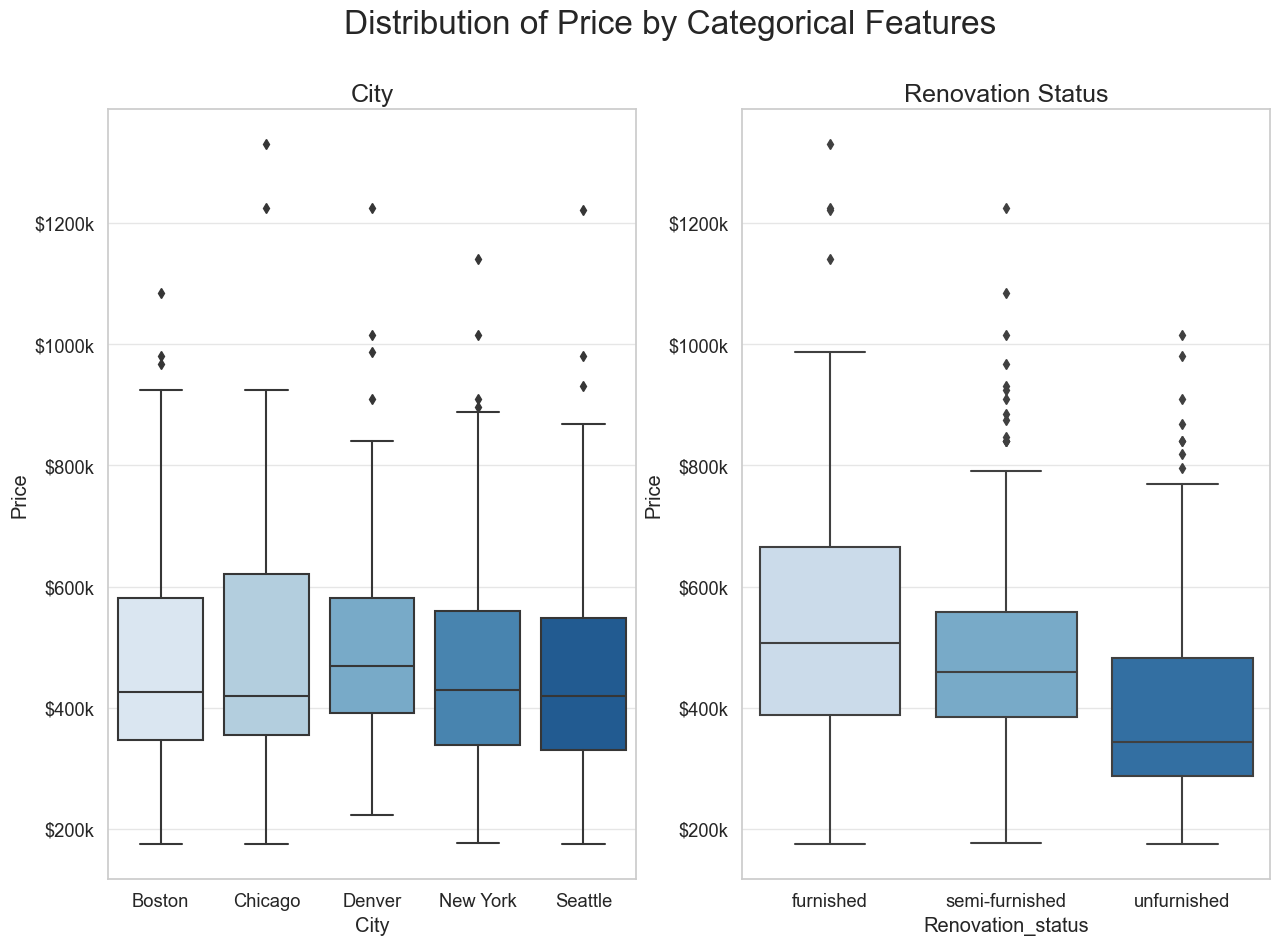

In [14]:
# Check distribution of price (in 1000s) by categorical features
fig, ax = plt.subplots(1, 2, figsize=(15, 10))

sns.set_context('notebook', font_scale=1.2)
sns.set_style('whitegrid', {'grid.color': '0.9'})

# Set title
fig.suptitle('Distribution of Price by Categorical Features', fontsize=24)

sns.boxplot(x='City', y='Price', data=df_eda, ax=ax[0], palette='Blues')
# Set subtitle
ax[0].set_title('City', fontsize=18)

sns.boxplot(x='Renovation_status', y='Price', data=df_eda, ax=ax[1], palette='Blues')
# Set subtitle
ax[1].set_title('Renovation Status', fontsize=18)

# Format y-axis
ax[0].yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: f'${x/1000:1.0f}k'))
ax[1].yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: f'${x/1000:1.0f}k'))


plt.show()

**Observations**:
- The distribution of price seems to be quite uniform across the different cities with Denver having the highest median price and the smallest Inter Quartile Range suggesting that housing prices in Denver are more consistent but also more expensive
- There is not a lot of outliers for the distribution of price across different cities
- The distribution of price across renovation status has a much more obvious difference with furnished having the highest median price followed by semi-furnished and unfurnished

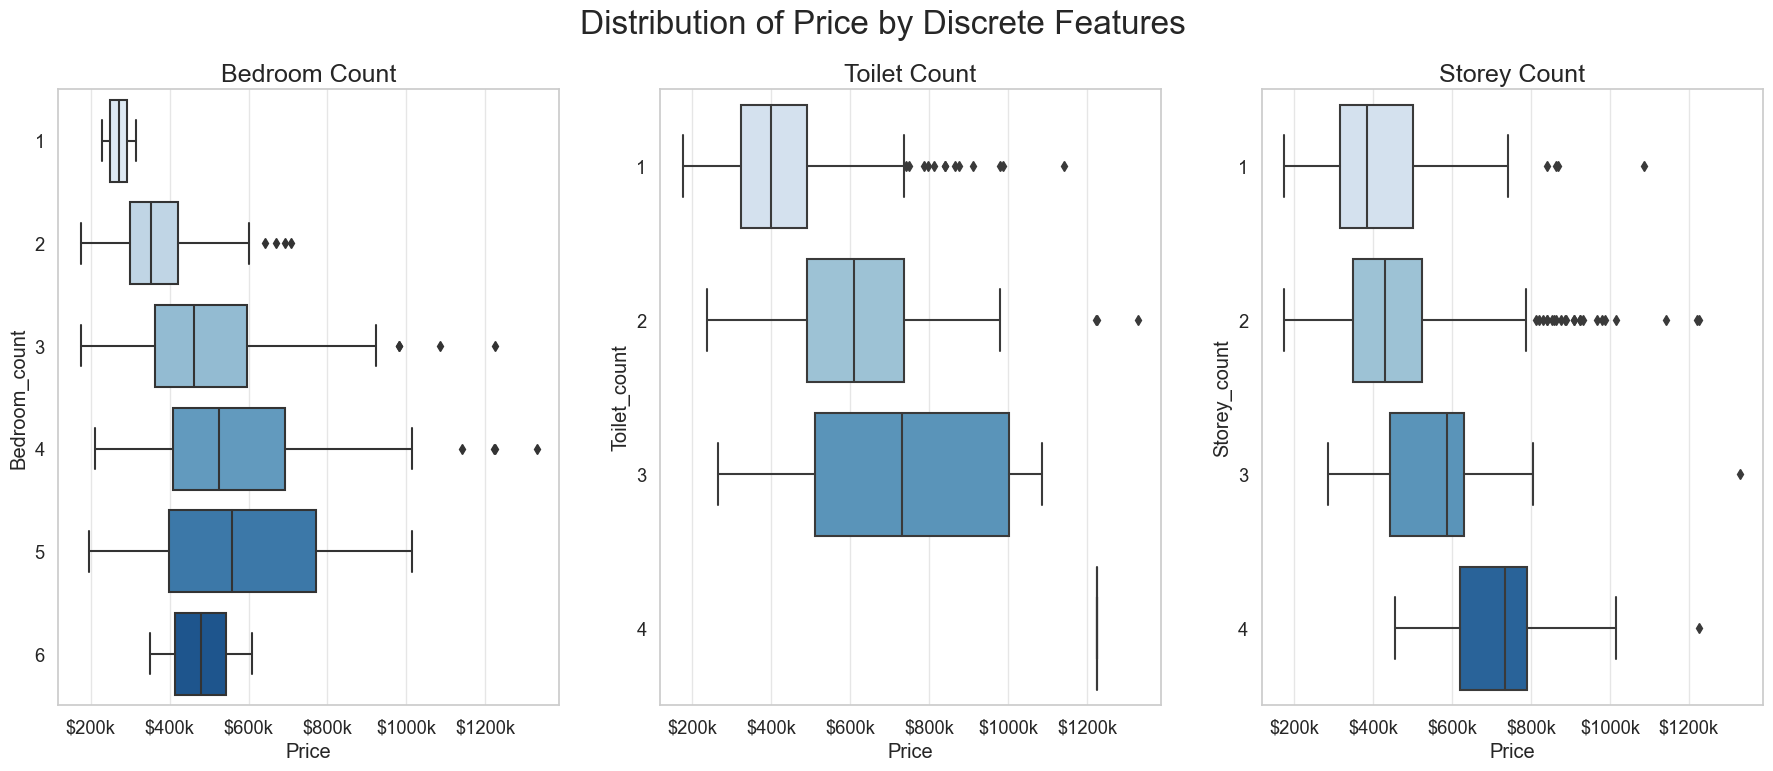

In [15]:
# Check distribution of price (in 1000s) by discrete features
fig, ax = plt.subplots(1, 3, figsize=(22, 8))

sns.set_context('notebook', font_scale=1.2)
sns.set_style('whitegrid', {'grid.color': '0.9'})

# Set title
fig.suptitle('Distribution of Price by Discrete Features', fontsize=24)

sns.boxplot(y='Bedroom_count', x='Price', orient='h', data=df_eda, ax=ax[0], palette='Blues')
# Set subtitle
ax[0].set_title('Bedroom Count', fontsize=18)

sns.boxplot(y='Toilet_count', x='Price', orient='h', data=df_eda, ax=ax[1], palette='Blues')
# Set subtitle
ax[1].set_title('Toilet Count', fontsize=18)

sns.boxplot(y='Storey_count', x='Price', orient='h', data=df_eda, ax=ax[2], palette='Blues')
# Set subtitle
ax[2].set_title('Storey Count', fontsize=18)

# Format y-axis
ax[0].xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: f'${x/1000:1.0f}k'))
ax[1].xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: f'${x/1000:1.0f}k'))
ax[2].xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: f'${x/1000:1.0f}k'))

plt.show()

**Observation**:
- The distribution of price is quite different across bedroom_count, toilet_count and storey_count with the median price increasing as each of the variables increase
- From the graph of toilet count against price, it seems that there may only be one house that had 4 toilets in this dataset

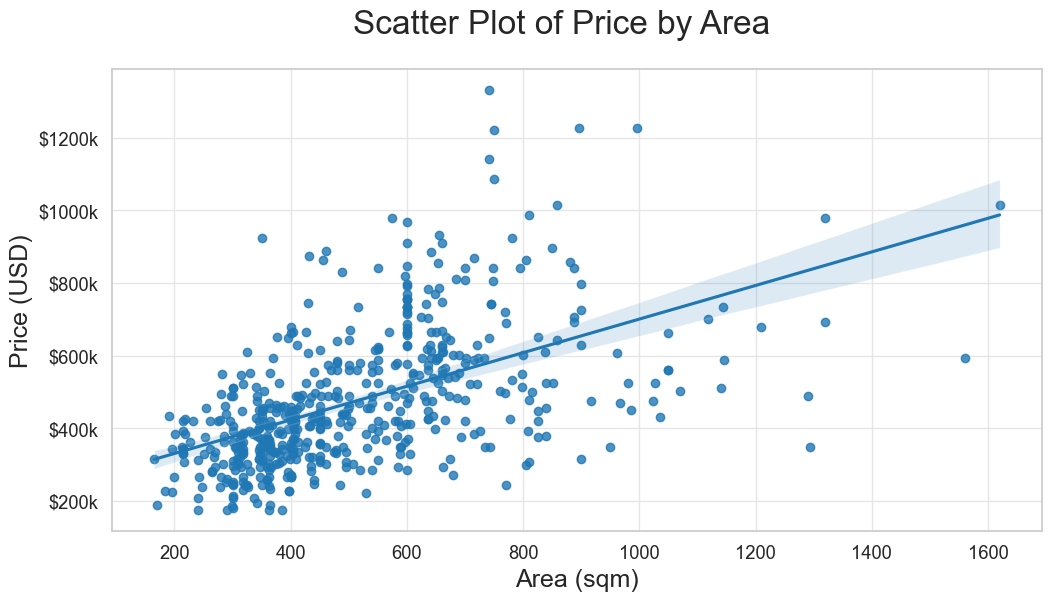

In [16]:
# Scatter plot of price (in 1000s) by area
fig, ax = plt.subplots(figsize=(12, 6))

sns.set_context('notebook', font_scale=1.2)
sns.set_style('whitegrid', {'grid.color': '0.9'})

# Set title
fig.suptitle('Scatter Plot of Price by Area', fontsize=24)

sns.regplot(x='Area', y='Price', data=df_eda, ax=ax)

# Format y-axis
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: f'${x/1000:1.0f}k'))

# Lable axis
ax.set_xlabel('Area (sqm)', fontsize=18)
ax.set_ylabel('Price (USD)', fontsize=18)

plt.show()

**Observations**:
- By comparing our two numerical columns, we can see a positve linear relationship between Area and Price of the House

#### **Pearon's r Correlation**

To check the correlation between the different numerical features, we will use Pearson's r correlation. The Pearson's r correlation is able to measure linear correlation between two variables.

**Formula**:
$\begin{equation}
\rho = \frac{COV(X,Y)}{\sigma_X\sigma_Y}
\end{equation}$

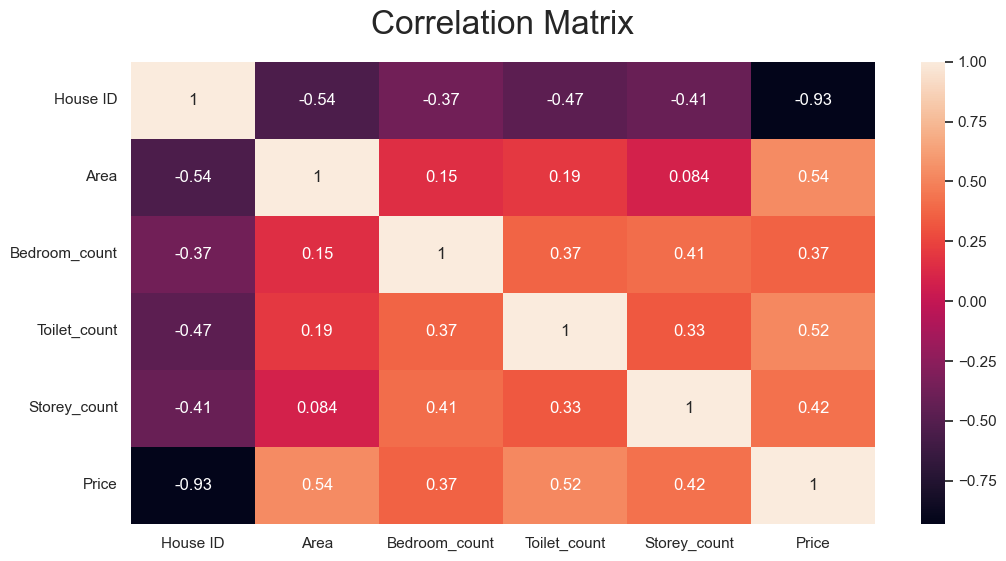

In [17]:
# Plot correlation matrix
plt.figure(figsize=(12, 6))

# Set font scale
sns.set_context('notebook', font_scale=1)

# Set grid color
sns.set_style('whitegrid', {'grid.color': '0.9'})

# Remove the frame
plt.box(False)

# Plot heatmap
sns.heatmap(df_eda.corr(), annot=True)

# Set title
plt.title('Correlation Matrix', fontsize=24, pad=20)

plt.show()

**Observations**:
- We can see that area of the house and number of toilets have a moderate positive correlation with the price of the house
- As for the other variables, there seems to be either no clear correlation or a very weak correlation

## 2. Data Preparation

Drop House ID since it is a redundant column

In [18]:
df.drop('House ID', axis=1, inplace=True)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   City               545 non-null    category
 1   Area               545 non-null    float64 
 2   Bedroom_count      545 non-null    int64   
 3   Toilet_count       545 non-null    int64   
 4   Storey_count       545 non-null    int64   
 5   Renovation_status  545 non-null    category
 6   Price              545 non-null    int64   
dtypes: category(2), float64(1), int64(4)
memory usage: 22.8 KB
None


In [19]:
X, y = df.drop('Price', axis=1), df['Price']

In [20]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=random_state)

In [21]:
# Reset index
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [22]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (436, 6)
X_test shape: (109, 6)


#### **Feature Engineering**

Feature Engineering is the process of creating new features from existing features in the dataset. For this dataset, a possible feature can be *House Base Area* which is defined as the base area of the house. By assuming that each storey has the same area, House Base Area can be approximated using

$\begin{equation}
House Base Area = \frac{Area}{Number of Storeys}
\nonumber
\end{equation}$

In [23]:
X_featureEng, y_featureEng = X_train.copy(), y_train.copy()
X_featureEng['House_Base_Area'] = X_featureEng['Area'] / X_featureEng['Storey_count']

display(X_featureEng[['Area', 'Storey_count', 'House_Base_Area']].head())

,Area,Storey_count,House_Base_Area
0,600.0,4,150.0
1,720.0,1,720.0
2,381.6,1,381.6
3,261.0,2,130.5
4,375.0,2,187.5


#### **Log Transform**

As seen previously from our EDA, area has a positively skewed distribution. As such, we will be applying log transformation on this feature.

$\begin{equation}
X' = log_e(1+X)
\nonumber
\end{equation}$

The reason it is more common to use 1 + X is because the log function has a domain of 0 < X < $\infty$ and some features may contain the value 0

In [24]:
X_logged, y_logged = X_featureEng.copy(), y_featureEng.copy()
# np.log1p() applies log(1+x) to all elements of the column
X_logged[['LoggedArea']] = np.log1p(X_logged[['Area']])

display(X_logged[['Area', 'LoggedArea']].head())

,Area,LoggedArea
0,600.0,6.398595
1,720.0,6.580639
2,381.6,5.946990
3,261.0,5.568345
4,375.0,5.929589


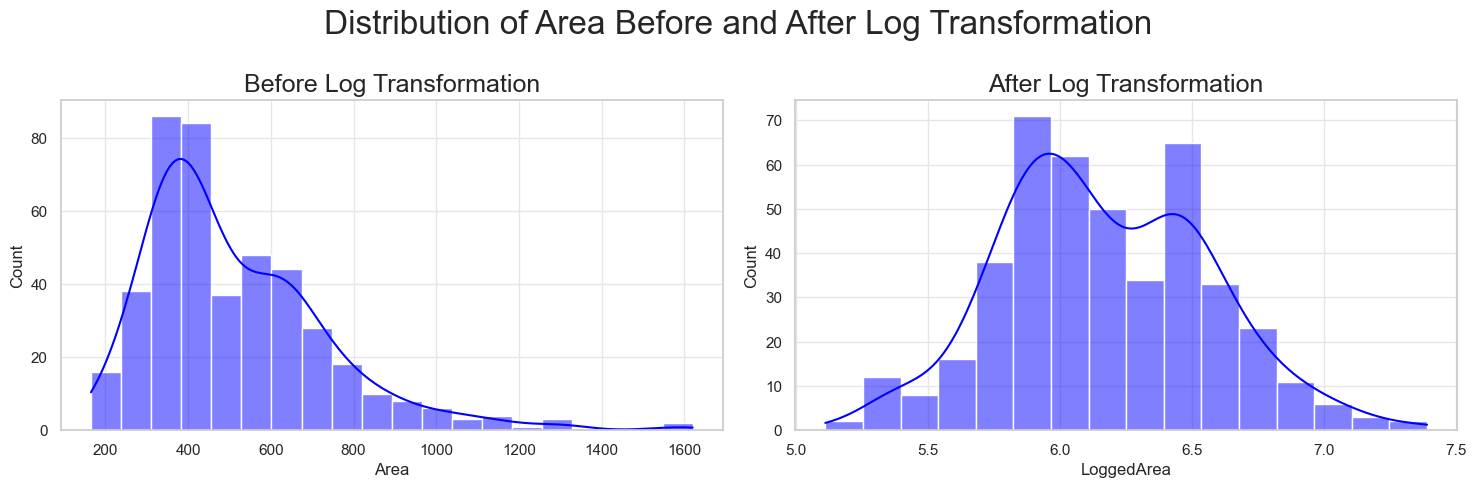

In [25]:
# Plot before and after log transformation
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.set_context('notebook', font_scale=1.2)
sns.set_style('whitegrid', {'grid.color': '0.9'})

# Set title
fig.suptitle('Distribution of Area Before and After Log Transformation', fontsize=24)

sns.histplot(X_logged['Area'], ax=ax[0], color='blue', kde=True)
# Set subtitle
ax[0].set_title('Before Log Transformation', fontsize=18)

sns.histplot(X_logged['LoggedArea'], ax=ax[1], color='blue', kde=True)
# Set subtitle
ax[1].set_title('After Log Transformation', fontsize=18)

plt.tight_layout()
plt.show()

**Observations**:

After the log transformation, the distribution of area transformed from being positively-skewed to being a normal and bimodial distribution

#### **Categorical Encoding**

As our dataset contains categorical data and many machine learning models can only work with numerical values, it is necessary to transform the categorical values of relevant features into numerical ones. This process is known as encoding and there are several ways to encode our data:

1. One Hot Encoder
2. Label Encoder
3. Ordinal Encoder

We will be using One Hot Encoder for our categorical features that are nominal such as City while we will be using Ordinal Encoder for our categorical features that are Ordinal such as Renovation Status

In [26]:
display(X_train['Renovation_status'].unique())

['furnished', 'semi-furnished', 'unfurnished']
Categories (3, object): ['furnished', 'semi-furnished', 'unfurnished']

In [27]:
X_enc, y_enc = X_logged.copy(), y_logged.copy()

# One hot encode categorical features
oneHotEnc = OneHotEncoder(categories='auto', sparse=False)
X_enc[['Boston','Chicago','Denver','New York','Seattle']] = pd.DataFrame(oneHotEnc.fit_transform(X_enc[['City']]))
print("ONE HOT ENCODED VALUES:")
display(X_enc[['Boston','Chicago','Denver','New York','Seattle','City']].head())

# Ordinal encode renovation status
ordinalEnc = OrdinalEncoder(categories=[['unfurnished', 'semi-furnished', 'furnished']])
X_enc['Renovation_statusEnc'] = ordinalEnc.fit_transform(X_enc[['Renovation_status']])
print("ORDINAL ENCODED VALUES:")
display(X_enc[['Renovation_statusEnc','Renovation_status']].head())

ONE HOT ENCODED VALUES:


,Boston,Chicago,Denver,New York,Seattle,City
0,0.0,0.0,0.0,1.0,0.0,New York
1,0.0,0.0,1.0,0.0,0.0,Denver
2,0.0,1.0,0.0,0.0,0.0,Chicago
3,1.0,0.0,0.0,0.0,0.0,Boston
4,0.0,0.0,0.0,0.0,1.0,Seattle


ORDINAL ENCODED VALUES:


,Renovation_statusEnc,Renovation_status
0,2.0,furnished
1,1.0,semi-furnished
2,2.0,furnished
3,0.0,unfurnished
4,0.0,unfurnished


#### **Feature Scaling**

Feature Scaling is the process of scaling numerical features within the dataset to a similar scale.



Certain Machine Learning Algorithms such as `Gradient Descent Based Algorithms` (e.g. Linear Regression, Ridge Regression, Perceptron) and `Distance Based Algorithms` (e.g. KNNRegressor and SVR) are more sensitive to feature scaling and requires the data to be scaled.

On the other hand, `Tree Based Algorithms` (e.g. RandomForest, GradientBoosting) are more insensitive to the scale of the features since trees only split a node based on a single feature. This means that other features do not influence this split which explains why different features can be of different scales

There are two popular ways to perform Feature Scaling:
1. Normaliation
2. Standardization

<u>Normalization</u>

Normalization also known as Min-Max scaling, is a scaling technique in which values are shifted and rescaled so that they end up ranging between 0 and 1. 

In SKLearn, Normalization can be implemented using `MinMaxScaler`

**Formula**:

$\begin{equation}
X' = \frac{X - X_{min}}{X_{max} - X_{min}}
\end{equation}$

<u>Standardization</u>

Standardization is another scaling method where values are centered around the mean with a unit standard deviation. This means that the mean of the feautre becomes zero and the distribution of the scaled feature has a unit standard deviation (or a standard deviation of 1).

In SKlearn, Standardization can be implemented using `StandardScaler`

**Formula**:

$\begin{equation}
X' = \frac{X - \mu}{\sigma}
\end{equation}$

Standardization vs Normalization

| Standardization | Normalization |
| --------------- | ------------- |
| Less Sensitive to outliers | Sensitive to outliers |
| Centers data around the mean and scales to a standard deviation of 1 | Rescales values to a range between 0 and 1 |
| Preserves the relationship between data points | May not preserve the relationship between the data points |
| Changes the shape of the original distribution | Retains the shape of the original distribution |


In [28]:
X_enc_scaled, y_enc_scaled = X_enc.copy(), y_enc.copy()

# Scale the data
scaler = StandardScaler()

numericColumns = ['Area', 'Bedroom_count', 'Toilet_count', 'Storey_count']

# Fot the scaler to the training data and transform
X_enc_scaled[numericColumns] = scaler.fit_transform(X_enc_scaled[numericColumns])
print("SCALED VALUES:")
display(X_enc_scaled[numericColumns].head())

SCALED VALUES:


,Area,Bedroom_count,Toilet_count,Storey_count
0,0.384168,0.055271,1.539173,2.587644
1,0.929181,0.055271,1.539173,-0.912499
2,-0.607755,-1.283514,-0.557950,-0.912499
3,-1.155492,0.055271,-0.557950,0.254215
4,-0.637730,0.055271,-0.557950,0.254215


## 4. Model Selection

In order to select a model for hyperparameter tuning, we will run the preprocessed data through some models and deem the best model based on the evaluation metrics to be chosen later

#### **Pipeline**

First, we will use a pipeline to preprocess the data (the same way as done in part 3) since a pipeline can help:
1. Improve ML Workflow
2. Prevent Data Leakage from the Train subset into the Test subset

In [29]:
# Creating Steps for Pipeline

# Function to log scale data
def log_scale(X):
    df = pd.DataFrame(X.reset_index(drop=True))
    # np.log1p() applies log(1+x) to all elements of the column
    df[['Area']] = np.log1p(df[['Area']])
    return df

# Feature engineering
def feature_engineering(X):
    df = pd.DataFrame(X.reset_index(drop=True))
    df['House_Base_Area'] = df['Area'] / df['Storey_count']
    return df

# Transformer for categorical features
categoricalTransformer = ColumnTransformer(
    [
        ('oneHotEnc', OneHotEncoder(categories='auto', sparse=False), ['City']),
        ('ordinalEnc', OrdinalEncoder(categories=[['unfurnished', 'semi-furnished', 'furnished']]), ['Renovation_status'])
    ],
    remainder='passthrough'
)

# Transformer for numeric features
numericTransformer = ColumnTransformer(
    [
        ('scaler', StandardScaler(), numericColumns)
    ],
    remainder='passthrough'
)

# Combine the transformers
preprocessor = ColumnTransformer(
    [
        ('categoricalTransformer', categoricalTransformer, ['City', 'Renovation_status']),
        ('numericTransformer', numericTransformer, numericColumns)
    ],
    remainder='passthrough'
)

numericColumns = ['Area', 'Bedroom_count', 'Toilet_count', 'Storey_count', 'House_Base_Area']

steps = [
    ('featureEngineering', FunctionTransformer(feature_engineering)),
    ('logScale', FunctionTransformer(log_scale)),
    ('preprocessor', preprocessor),
    ('model')
]

model_step = len(steps) - 1

#### **Evaluation Metrics**

<u>Mean Squared Error</u>

Mean Squared Error is the sum of error at each point (error is the square of actual - predicted at a point) divided by the total number of points

**Formula**:
$ \begin{equation}
MSE = \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{n}
\nonumber
\end{equation}$

<u>Root Mean Squared Error</u>

Root Mean Squared Error the square root of the Mean Squared Error. 

**Formula**:
$ \begin{equation}
RMSE = \sqrt{\frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{n}}
\nonumber
\end{equation}$

<u>R2</u>

R2, also known as the coefficient of determinant, measures the proportion of variance in the dependent variable that can be explained by the independent variables in a regression model

**Formula**:

$ \begin{equation}
R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}
\nonumber
\end{equation}$


*Note: SKLearn returns RMSE and MSE as negative values instead of positive values when using the scorers from `sklearn.metrics.get_scorer_names`. This is because functions like GridSearchCV always tries to maximize its score so loss functions like MSE and RMSE have o be negated (so a MSE of -5 is better than -9 and -5 > -9)*

Typically, we use RMSE more often than MSE because RMSE is measured in the same units as the target variable while MSE is measured in squared units of the target variable.

As such, we will be using:
-  **RMSE** 
-  **R2** 

as our evaluation metrics to try and evaluate our models

In [30]:
# Use scorers from sklearn.metrics for evaluation in cross validation
evaluation_metrics = {
    'neg_RMSE': 'neg_root_mean_squared_error',
    'RMSE': make_scorer(mean_squared_error, squared=False),
    'r2': 'r2'
}

In [31]:
def plot_learning_curve(
    model,
    X,
    y,
    scoring,
    cv=KFold(shuffle=True, random_state=random_state),
    train_sizes=np.linspace(0.1, 1.0, 10),
    ax=None,
):
    try:
        model_name = type(model[-1].regressor).__name__
    except:
        try:
            model_name = type(model[-1]).__name__
        except:
            model_name = type(model).__name__
            
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        model,
        X,
        y,
        cv=cv,
        n_jobs=-1,
        train_sizes=train_sizes,
        return_times=True,
        scoring=scoring,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    ax.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    ax.plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    ax.legend(loc="best")
    ax.set(
        ylim=(
            min(np.nanmin(train_scores), np.nanmin(test_scores)) - 0.1,
            1.0,
        )
    )
    ax.set_title(f"Learning Curve of {model_name}")
    ax.set_ylabel(f"{scoring}")
    ax.set_xlabel("Train Sizes")
    return ax

In [32]:
# Instantiate the models
models = [
    ('Linear Regression', LinearRegression()),
    ('Decision Tree Regressor', DecisionTreeRegressor(random_state=random_state)),
    ('Random Forest Regressor', RandomForestRegressor(random_state=random_state)),
    ('Gradient Boosting Regressor', GradientBoostingRegressor(random_state=random_state)),
    ('Ada Boost Regressor', AdaBoostRegressor(random_state=random_state)),
    ('Elastic Net Regressor', ElasticNet(random_state=random_state)),
    ('Ridge', Ridge(random_state=random_state)),
    ('Lasso', Lasso(random_state=random_state)),
]

##### <u> Models Explained </u>

1. `Linear Regression`

Linear Regression is one of the most simple models for regression problems. It fits a linear function

$\begin{equation}
f(x) = mx + c
\nonumber
\end{equation}$

to try and predict the value of a variable based on previous values


2. `Decision Tree`

A decision tree is the simplest of all tree-based model. The base of the tree is the root node and from the root node flows a series of decision nodes. Each decision node can then be split into further sub-nodes. Nodes that no longer split are called leaf or terminal nodes. The main contributor affecting the decision tree's accuracy is how each decision node is split 

3. `Random Forest` 

In Random Forest, bagging is used to generate multiple training sets with replacement (i.e. the initial dataset is divided into multiple datasets using randomized sampling). Then a single decision tree is built on each sample before the resultant prediction is combined using either voting or averaging in parallel


4. `Gradient Boosting`

Gradient Boosting is similar to Random Forest in that it is also made up of an ensemble of Decision Trees. However, instead of using a single tree to build on each sample, each new tree is built to improve on the deficiencies of the previous tree (also known as boosting). This is done by minimising the loss function as the algorithm builds each tree

5. `Ada Boost`

AdaBoost, also called Adaptive Boost, is like Gradient Boosting since it also combines a number of weak trees to form a stronger tree. However, AdaBoost was designed for a specific loss function (exponential loss function) while Gradient Boosting is a more generic algorithm that can use any differentiable loss function

6. `Ridge`

Ridge Regression performs L2 regularization for a linear regression model to prevent it from overfitting.

$\begin{align}
Ridge(w,b) &= error function + L2 regularization term \\
\nonumber
&= \frac{1}{n}\sum_{i=1}^{n} (y_i - \hat{y}_i)^2 + \lambda \sum_{j=1}^{p} w_{j}^{2}
\nonumber
\end{align}$

In Ridge Regression, the coefficient can be reduced but it will never reach 0 (none of the features will be removed)

7. `Lasso`

Lasso Regression performs L1 regularization for a linear regression model to prevent it from overfitting.

$\begin{align}
Lasso(w,b) &= error function + L2 regularization term \\
\nonumber
&= \frac{1}{n}\sum_{i=1}^{n} (y_i - \hat{y}_i)^2 + \lambda \sum_{j=1}^{p} |w_{j}|
\nonumber
\end{align}$

In Lasso Regression, it is possible for the coefficient of a feature to be reduced to 0 (the feature is removed)

8. `ElasticNet`

Elastic Net combines L1 and L2 as a regularizer. l1_ratio is used as the mixing parameter

$\begin{equation}
regularization term = \lambda \sum_{j=1}^{p} (l1_{ratio} \cdot |w_{j}| + (1-l1_{ratio}) \cdot w_{j}^{2})
\nonumber
\end{equation}$

,fit_time,score_time,test_neg_RMSE,test_RMSE,test_r2
Gradient Boosting Regressor,0.094989,0.013712,-114211.740498,114211.740498,0.514082
Ridge,0.017615,0.011436,-116723.147660,116723.147660,0.500383
Lasso,0.019663,0.011674,-116769.161245,116769.161245,0.499831
Linear Regression,0.020379,0.013836,-116770.110463,116770.110463,0.499821
Elastic Net Regressor,0.019530,0.012390,-118596.384707,118596.384707,0.497782
Random Forest Regressor,0.368272,0.027264,-117830.306098,117830.306098,0.489753
Ada Boost Regressor,0.115090,0.019573,-128467.748941,128467.748941,0.379562
Decision Tree Regressor,0.020253,0.013098,-156127.005456,156127.005456,0.048414


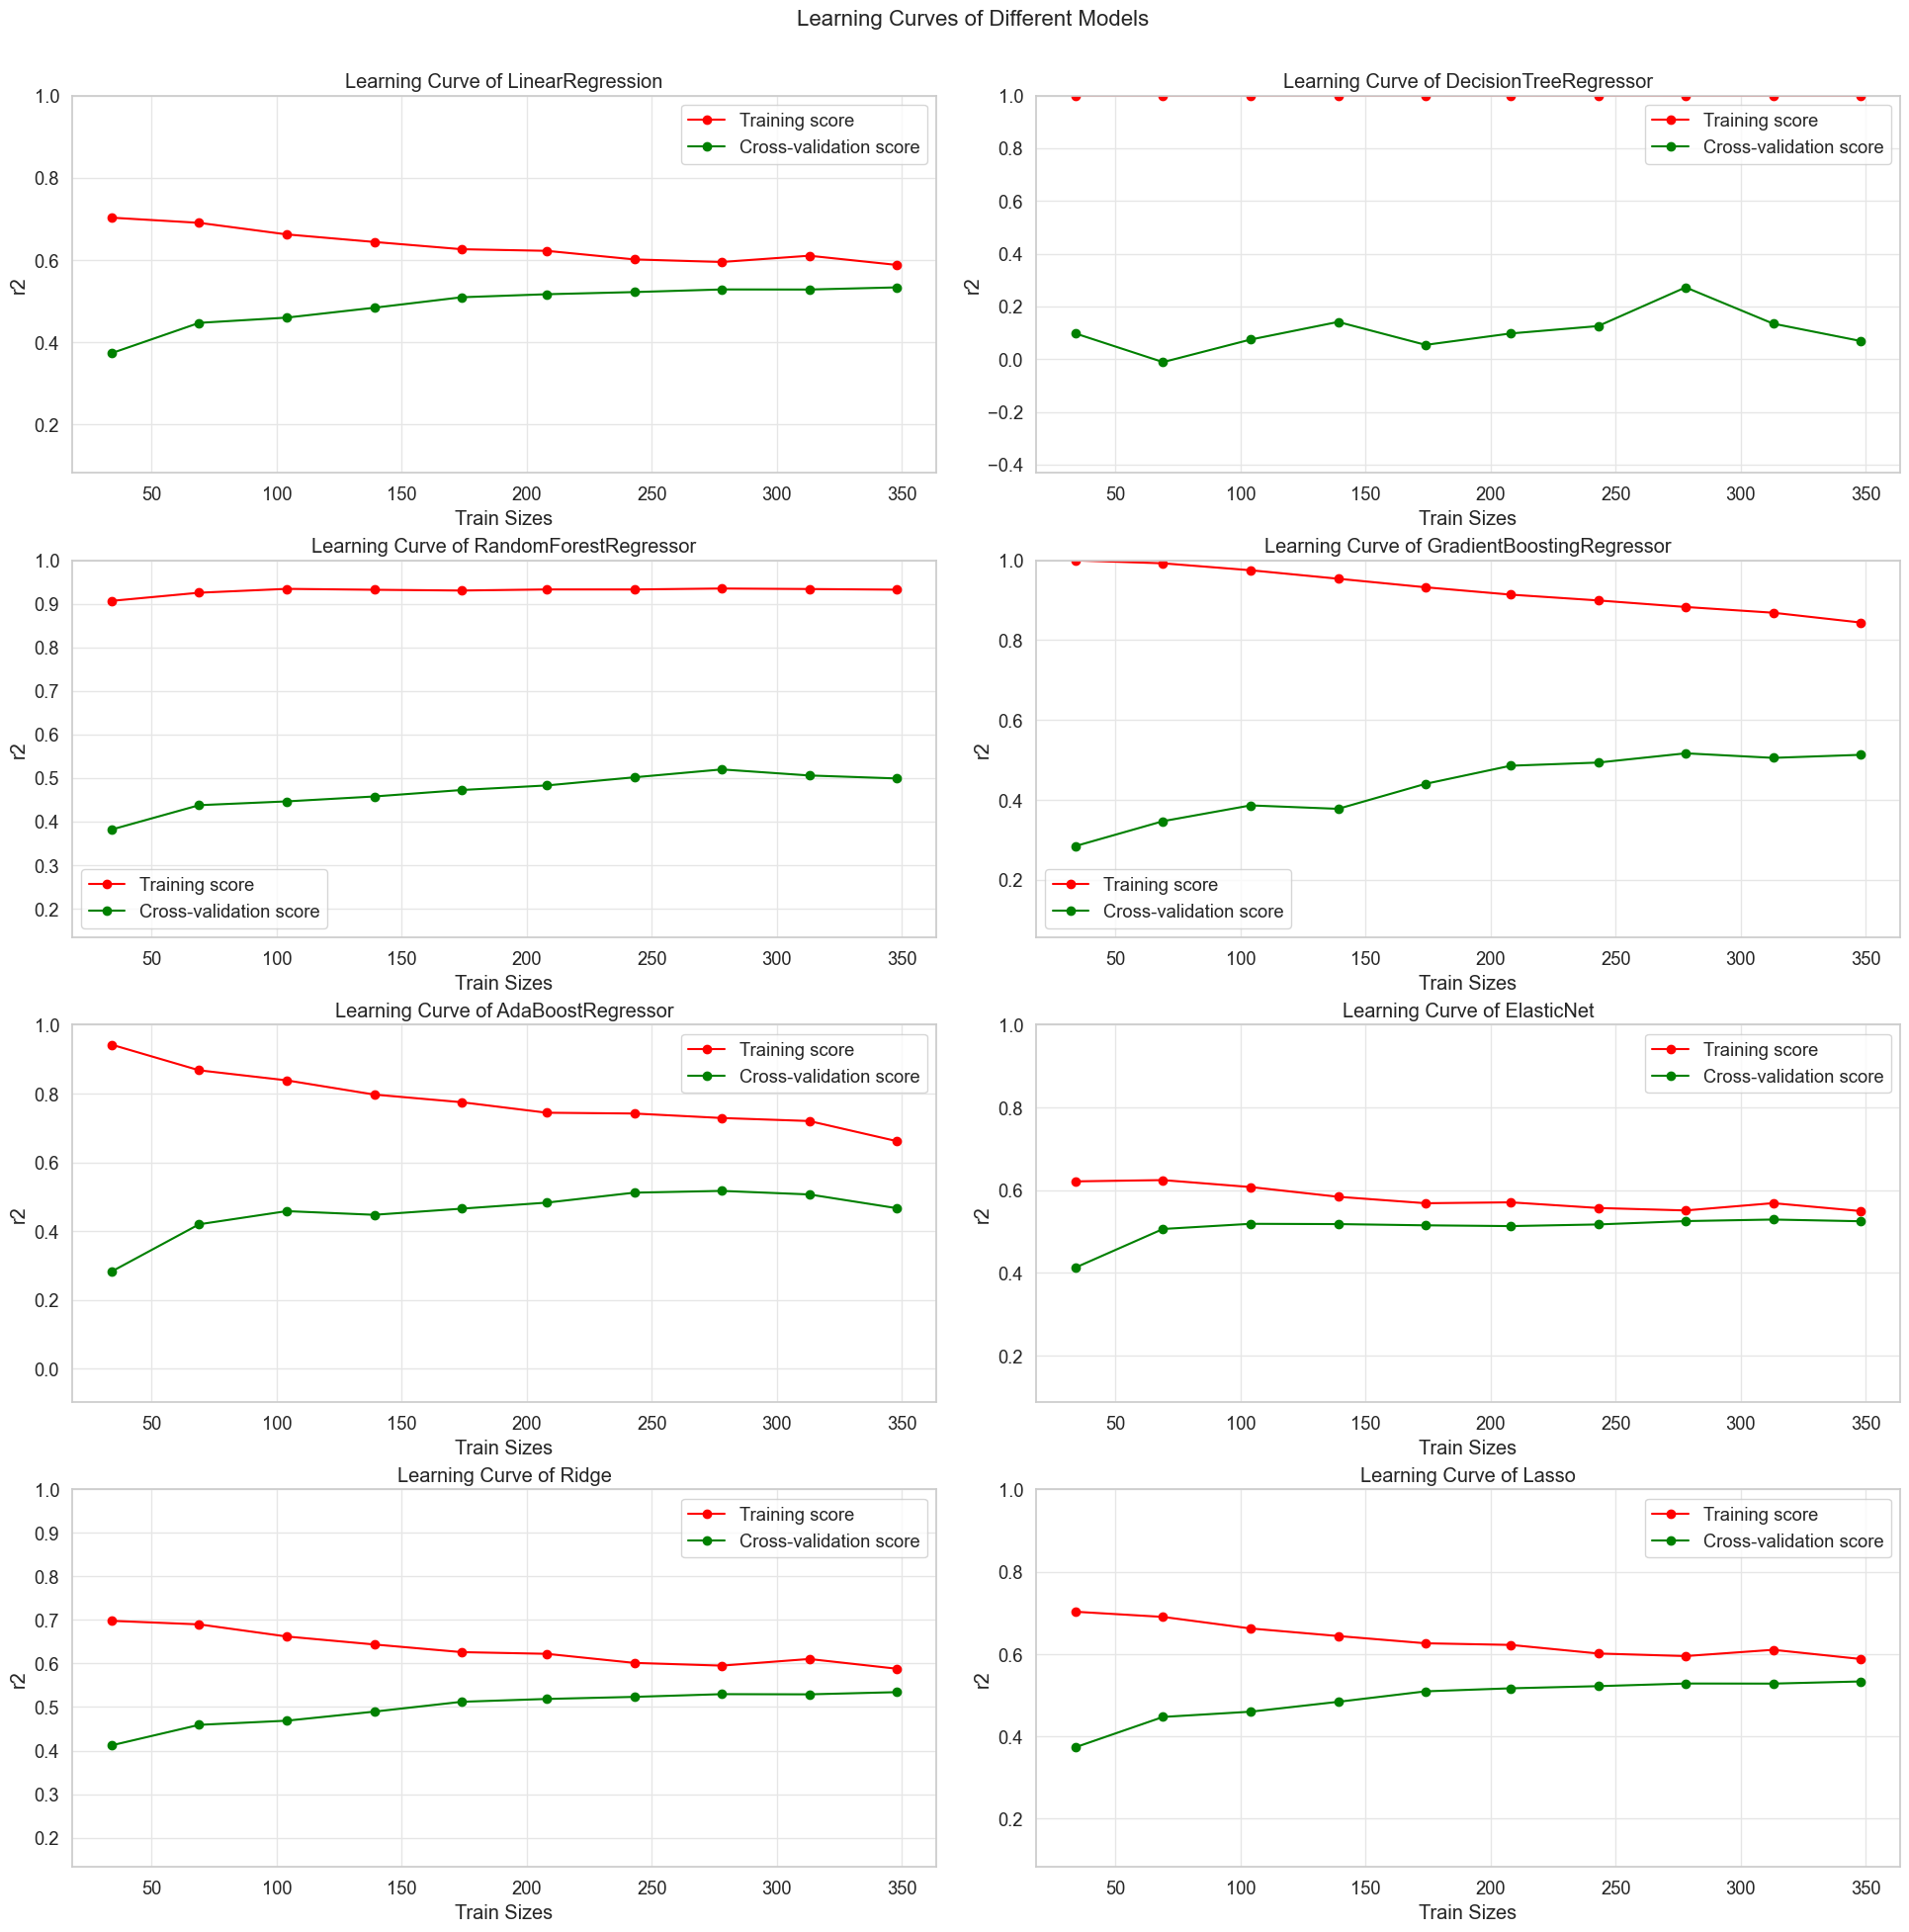

In [33]:
Final_Score = pd.DataFrame()

fig,ax = plt.subplots(4, 2, figsize=(20, 20))
fig.set_facecolor('white')
# Set title
fig.suptitle("Learning Curves of Different Models", fontsize=16)

# Set padding between each subplot
fig.tight_layout(pad=2.5)

for name, model in models:
    steps[model_step] = ('model', model)
    pipe = Pipeline(steps=steps)
    # Plot learning curve 
    plot_learning_curve(
            pipe,
            X_train,
            y_train,
            scoring='r2',
            ax=ax[models.index((name, model))//2, models.index((name, model))%2]
        )
    # Cross validate
    scores = pd.DataFrame(cross_validate(pipe, X_train, y_train, scoring=evaluation_metrics, cv=10, return_train_score=False, n_jobs=-1)).mean(axis=0)
    Final_Score[name] = scores

display(Final_Score.sort_values(
    by=[
        'test_r2',
        'test_neg_RMSE'
    ],
    ascending=False,
    axis=1
).T)


**Observations**:
- In general, it seems that gradient descent based models perform slightly better than tree based models. As seen in the learning curve for Random Forest Classifier and Decision Tree Classifier, it seems very likely that there is overfitting in the tree based models
- Both SVR and descision trees seemed to have performed really poorly with negative r2 scores suggesting a poor correlation

However, since the difference in r2 score and RMSE between gradient boosting and the other gradient descent model is not a lot, we will selecting three models for hyperparameter tuning. They are:
- Gradient Boosting (since it has the lowest RMSE and highest r2)
- Ridge (since it has the second highest r2)
- Elastic Net (since it combines L1 Lasso with L2 Ridge and might be able to provide better results after tuning)

**Initializing Ridge**

In [34]:
# Ridge
steps[model_step] = ('model', Ridge(random_state=random_state))

Ridge_reg = Pipeline(steps=steps)
Ridge_reg.fit(X_train, y_train)
scores = pd.DataFrame(cross_validate(
    Ridge_reg,
    X_train,
    y_train,
    cv=10,
    scoring=evaluation_metrics,
    n_jobs=-1,
    return_train_score=True,
))
scores.loc['mean'] = scores.mean(axis=0)
# displaying scores
display(scores)

,fit_time,score_time,test_neg_RMSE,train_neg_RMSE,test_RMSE,train_RMSE,test_r2,train_r2
0,0.017560,0.011753,-115388.831673,-113306.700834,115388.831673,113306.700834,0.420431,0.590997
1,0.020862,0.014572,-131245.917723,-111288.208462,131245.917723,111288.208462,0.593503,0.571838
2,0.017810,0.013421,-126533.766588,-111568.711284,126533.766588,111568.711284,0.604624,0.577964
3,0.022012,0.016484,-94734.496278,-115224.116215,94734.496278,115224.116215,0.464076,0.590121
4,0.022547,0.018230,-102642.100825,-114551.287308,102642.100825,114551.287308,0.302735,0.594446
5,0.020686,0.016947,-85782.544434,-116019.754669,85782.544434,116019.754669,0.547795,0.584390
6,0.023670,0.016459,-139011.084155,-110088.934797,139011.084155,110088.934797,0.505769,0.593934
7,0.024212,0.016460,-125013.644055,-112025.337842,125013.644055,112025.337842,0.541047,0.588252
8,0.023924,0.014466,-117993.022432,-112778.223450,117993.022432,112778.223450,0.673120,0.569442
9,0.026431,0.011994,-128886.068435,-111516.302973,128886.068435,111516.302973,0.350735,0.603512


**Initializing ElasticNet**

In [35]:
# ElasticNet
steps[model_step] = ('model', ElasticNet(random_state=random_state))

ElasticNet_reg = Pipeline(steps=steps)
ElasticNet_reg.fit(X_train, y_train)
scores = pd.DataFrame(cross_validate(
    ElasticNet_reg,
    X_train,
    y_train,
    cv=10,
    scoring=evaluation_metrics,
    n_jobs=-1,
    return_train_score=True,
))
scores.loc['mean'] = scores.mean(axis=0)
# displaying scores
display(scores)

,fit_time,score_time,test_neg_RMSE,train_neg_RMSE,test_RMSE,train_RMSE,test_r2,train_r2
0,0.015892,0.014145,-114168.577436,-118368.218245,114168.577436,118368.218245,0.432624,0.553640
1,0.021616,0.013971,-143875.719850,-115771.688685,143875.719850,115771.688685,0.511504,0.536644
2,0.020424,0.010986,-135837.393112,-116329.593960,135837.393112,116329.593960,0.544345,0.541177
3,0.016468,0.011983,-95131.126272,-119908.435762,95131.126272,119908.435762,0.459579,0.556117
4,0.020383,0.014432,-98932.616167,-119445.473706,98932.616167,119445.473706,0.352223,0.559052
5,0.020112,0.016067,-72238.977377,-121526.528061,72238.977377,121526.528061,0.679314,0.544001
6,0.016079,0.014961,-144468.981680,-115167.451629,144468.981680,115167.451629,0.466197,0.555605
7,0.021408,0.016478,-132147.315664,-116889.938265,132147.315664,116889.938265,0.487174,0.551716
8,0.022206,0.014607,-128978.388503,-117643.502355,128978.388503,117643.502355,0.609420,0.531492
9,0.020305,0.013150,-120184.751014,-116927.701905,120184.751014,116927.701905,0.435441,0.564099


**Initializing Gradient Boosting**

In [36]:
# Gradient Boosting
steps[model_step] = ('model', GradientBoostingRegressor(random_state=random_state))

GB_reg = Pipeline(steps=steps)
GB_reg.fit(X_train, y_train)
scores = pd.DataFrame(cross_validate(
    GB_reg,
    X_train,
    y_train,
    cv=10,
    scoring=evaluation_metrics,
    n_jobs=-1,
    return_train_score=True,
))
scores.loc['mean'] = scores.mean(axis=0)
# displaying scores
display(scores)

,fit_time,score_time,test_neg_RMSE,train_neg_RMSE,test_RMSE,train_RMSE,test_r2,train_r2
0,0.091422,0.024847,-118570.709375,-72136.675173,118570.709375,72136.675173,0.388027,0.834222
1,0.111870,0.019413,-127878.076786,-74574.341418,127878.076786,74574.341418,0.614097,0.807740
2,0.106105,0.019299,-114548.702098,-73160.269848,114548.702098,73160.269848,0.675976,0.818526
3,0.102872,0.016298,-92280.150275,-73578.888015,92280.150275,73578.888015,0.491486,0.832862
4,0.110871,0.017516,-100363.980597,-73886.544629,100363.980597,73886.544629,0.333343,0.831275
5,0.111403,0.017437,-98268.123430,-73867.110548,98268.123430,73867.110548,0.406580,0.831529
6,0.112937,0.015373,-107493.012169,-73195.601259,107493.012169,73195.601259,0.704477,0.820494
7,0.108356,0.015373,-123636.167068,-73988.865892,123636.167068,73988.865892,0.551105,0.820389
8,0.105224,0.013619,-136648.158220,-70236.572356,136648.158220,70236.572356,0.561587,0.833003
9,0.109464,0.011689,-122430.324966,-69957.697641,122430.324966,69957.697641,0.414148,0.843964


**Compare model with dummy baseline**

In [37]:
# Dummy Classifier
dummy_reg = Pipeline(steps=steps)

steps[model_step] = ("model", DummyRegressor(strategy="median"))

dummy_reg = Pipeline(steps=steps)
dummy_reg.fit(X_train, y_train)
scores = pd.DataFrame(cross_validate(
    dummy_reg,
    X_train,
    y_train,
    cv=10,
    scoring=evaluation_metrics,
    n_jobs=-1,
    return_train_score=True,
))
scores.loc['mean'] = scores.mean(axis=0)
# displaying scores
display(scores)

,fit_time,score_time,test_neg_RMSE,train_neg_RMSE,test_RMSE,train_RMSE,test_r2,train_r2
0,0.012039,0.010963,-152676.280807,-181315.299854,152676.280807,181315.299854,-0.014660,-0.047331
1,0.014259,0.012953,-237742.386037,-174958.680618,237742.386037,174958.680618,-0.333827,-0.058232
2,0.018940,0.013834,-221427.028561,-176817.586588,221427.028561,176817.586588,-0.210762,-0.060025
3,0.013954,0.010967,-131727.750191,-184356.947901,131727.750191,184356.947901,-0.036194,-0.049272
4,0.018938,0.013772,-123148.397638,-184626.208667,123148.397638,184626.208667,-0.003700,-0.053501
5,0.019817,0.009089,-128410.979954,-185033.062050,128410.979954,185033.062050,-0.013308,-0.057111
6,0.018305,0.011599,-209707.998363,-177510.244119,209707.998363,177510.244119,-0.124764,-0.055738
7,0.016690,0.010220,-190609.627249,-179663.994665,190609.627249,179663.994665,-0.066948,-0.059062
8,0.018937,0.014858,-211817.560815,-176315.565888,211817.560815,176315.565888,-0.053416,-0.052356
9,0.016069,0.013862,-161367.099180,-182063.635719,161367.099180,182063.635719,-0.017748,-0.056817


We will be comparing our three models with a dummy baseline model. The comparison will be done through:
- Residual Plot
- Prediction Error Plot
- Learning Curve

**Residual Plot**

In [38]:
def plot_residuals(model, X, y, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))

    try:
        model_name = type(model[-1].regressor).__name__
    except:
        try:
            model_name = type(model[-1]).__name__
        except:
            model_name = type(model).__name__
    
    y_pred = model.predict(X)
    residuals = y - y_pred

    ax.scatter(range(len(residuals)), residuals, alpha=0.5)

    ax.set_xlabel("Predicted Values")
    ax.set_ylabel("Residuals")
    ax.set_title(f"Residual Plot of {model_name}")
    ax.axhline(0, color="red", linestyle='--')
    
    return ax

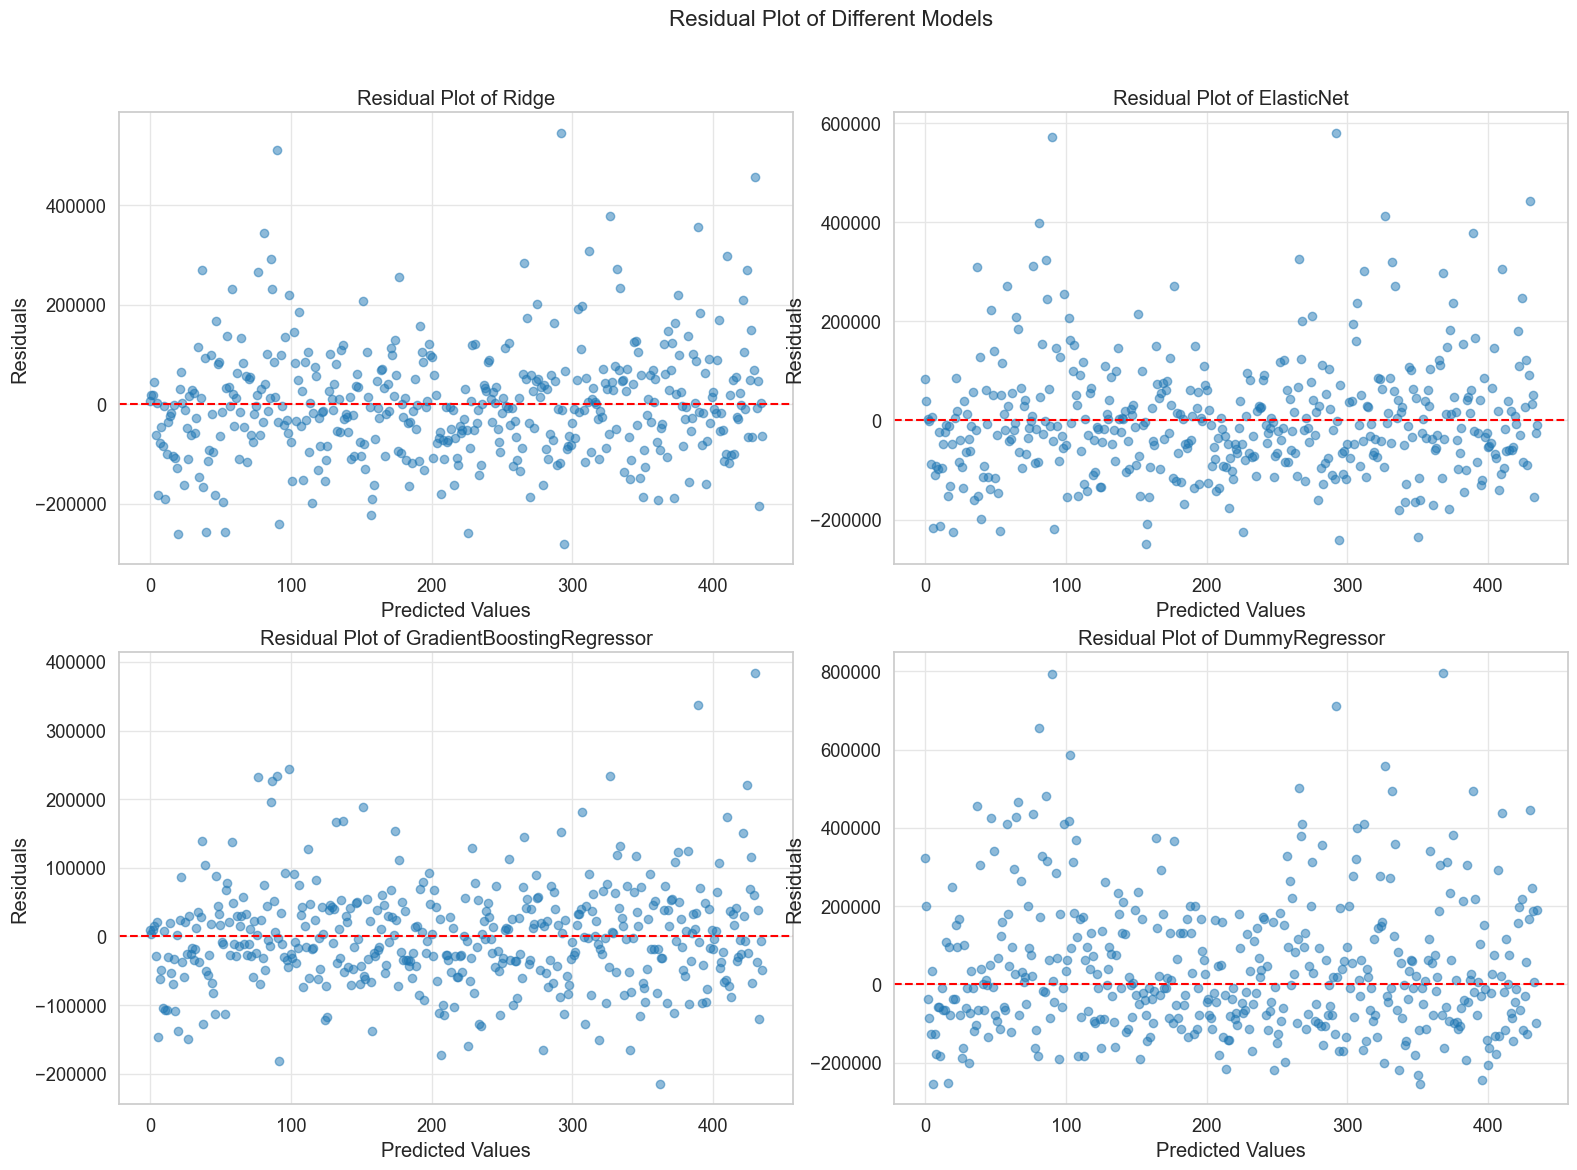

In [39]:
# Plot residual plot
fig, ax = plt.subplots(2, 2, figsize=(16, 12))

fig.suptitle("Residual Plot of Different Models", fontsize=16)

fig.tight_layout(pad=2.5)

# Ridge
plot_residuals(
    Ridge_reg,
    X_train,
    y_train,
    ax=ax[0, 0],
)

# Ridge
plot_residuals(
    ElasticNet_reg,
    X_train,
    y_train,
    ax=ax[0, 1],
)

# Gradient Boosting
plot_residuals(
    GB_reg,
    X_train,
    y_train,
    ax=ax[1, 0],
)

# Dummy Classifier
plot_residuals(
    dummy_reg,
    X_train,
    y_train,
    ax=ax[1, 1],
)

plt.show()

**Observations**:

- From the residual plot, it seems that GradientBoosting and Ridge regression are preforming better than ElasticNet since its residuals have fewer outliers
- Although there are quite a lot of residuals for all the models, the residuals are the most random for the DummyRegressor with differences between actual and predicted reaching about 800 000

**Prediction Error Plot**

In [40]:
def plot_prediction_error(model, X, y, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
    try:
        model_name = type(model[-1].regressor).__name__
    except:
        try:
            model_name = type(model[-1]).__name__
        except:
            model_name = type(model).__name__

    y_pred = model.predict(X)
    
    ax.scatter(y, y_pred, c="red", marker='x')
    p1 = max(max(y_pred), max(y_test))
    p2 = min(min(y_pred), min(y_test))
    ax.plot([p1, p2], [p1, p2], "b--", label="Identity")
    a, b = np.polyfit(y, y_pred, 1)
    ax.plot(y, a * y + b, "g-", label="Best Fit")
    ax.legend()
    ax.set_xlabel("True Values")
    ax.set_ylabel("Predictions")
    ax.set_title(f"Prediction Error Plot using {model_name}")
    print(f"{model_name}'s R2: {r2_score(y,y_pred):.3f}")
    return ax

Ridge's R2: 0.585
ElasticNet's R2: 0.549
GradientBoostingRegressor's R2: 0.818
DummyRegressor's R2: -0.056


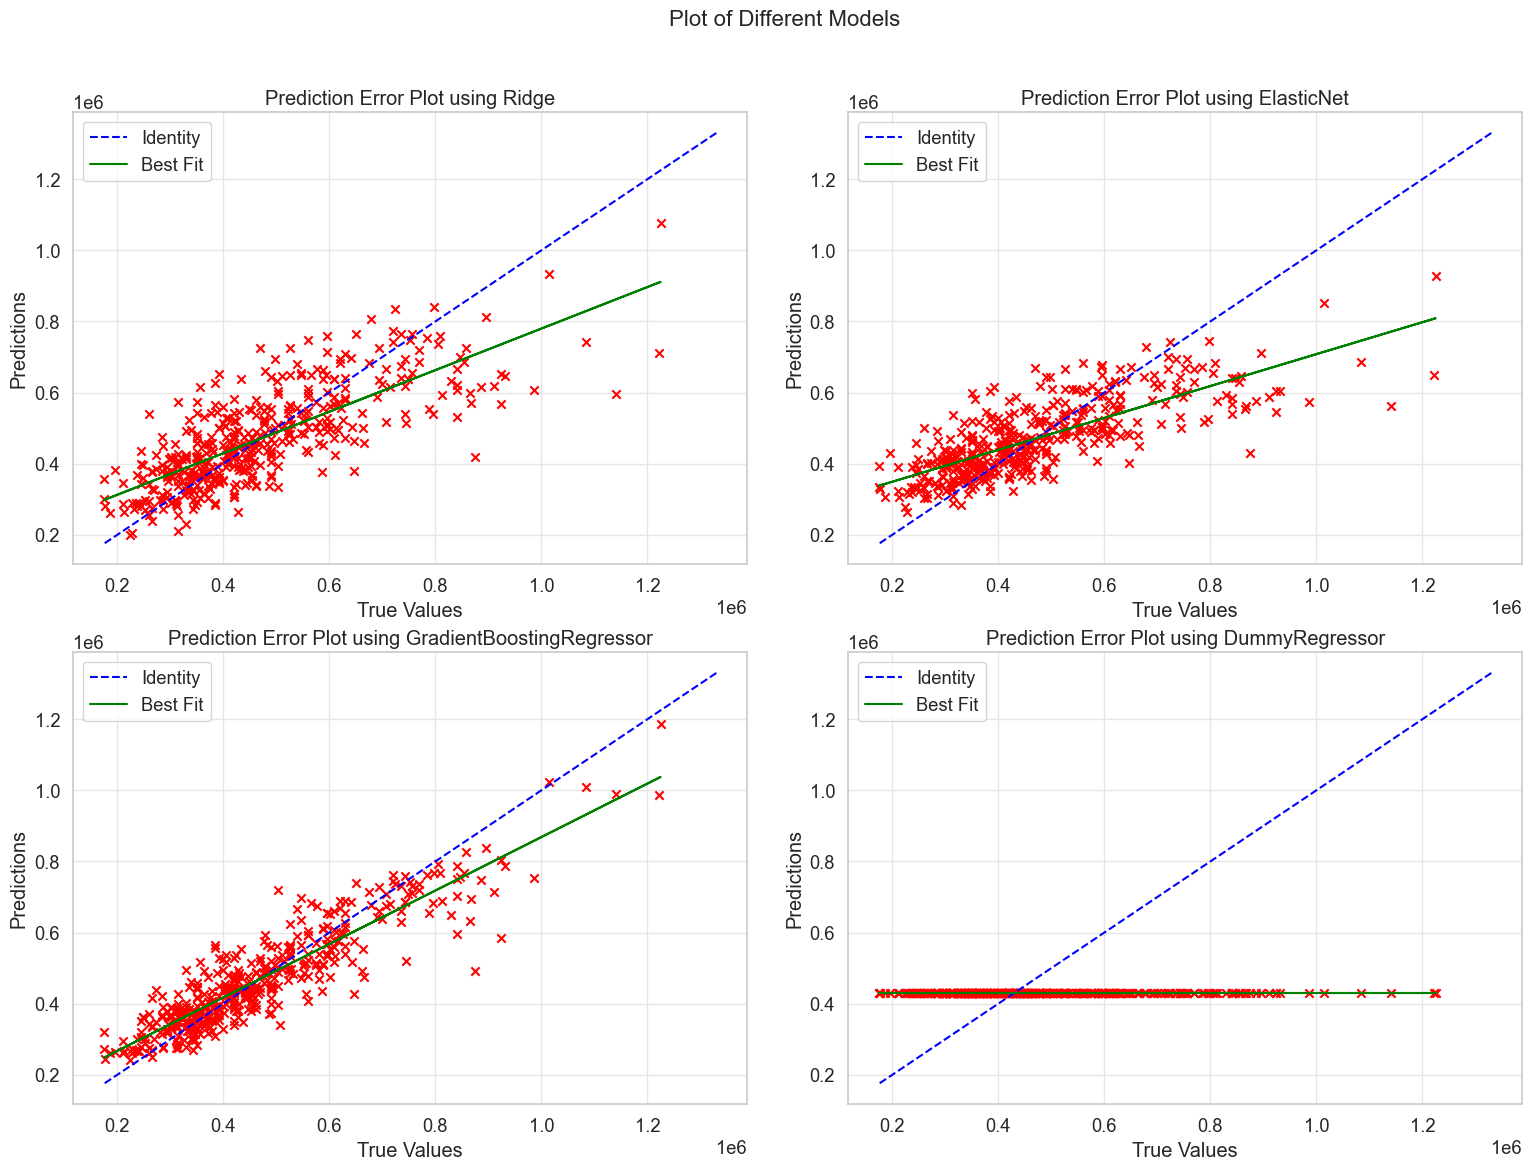

In [41]:
# Plot prediction error plot
fig, ax = plt.subplots(2, 2, figsize=(16, 12))

fig.suptitle("Plot of Different Models", fontsize=16)

fig.tight_layout(pad=2.5)

# Ridge
plot_prediction_error(
    Ridge_reg,
    X_train,
    y_train,
    ax=ax[0, 0],
)

# ElasticNet
plot_prediction_error(
    ElasticNet_reg,
    X_train,
    y_train,
    ax=ax[0, 1],
)

# Gradient Boosting
plot_prediction_error(
    GB_reg,
    X_train,
    y_train,
    ax=ax[1, 0],
)

# Dummy Classifier
plot_prediction_error(
    dummy_reg,
    X_train,
    y_train,
    ax=ax[1, 1],
)

plt.show()

A prediction error plot shows the actual targets from the dataset against the predicted values generated by the model. The 45 degree line ,also known as the identity line, is the line where the prediction exactly matches the model

**Observations**:
- We notice that DummyRegressor's best fit line is very far away from the identity line which suggests that the model completely does no foloow the trend of the prices
- Gradient Boosting's best fit line is the closest to the identity line compared to the other model since it is lying slightly to the bottom of the identity line. This suggests that Gradient Boosting is performing better than Ridge and ElasticNet



**Learning Curve**

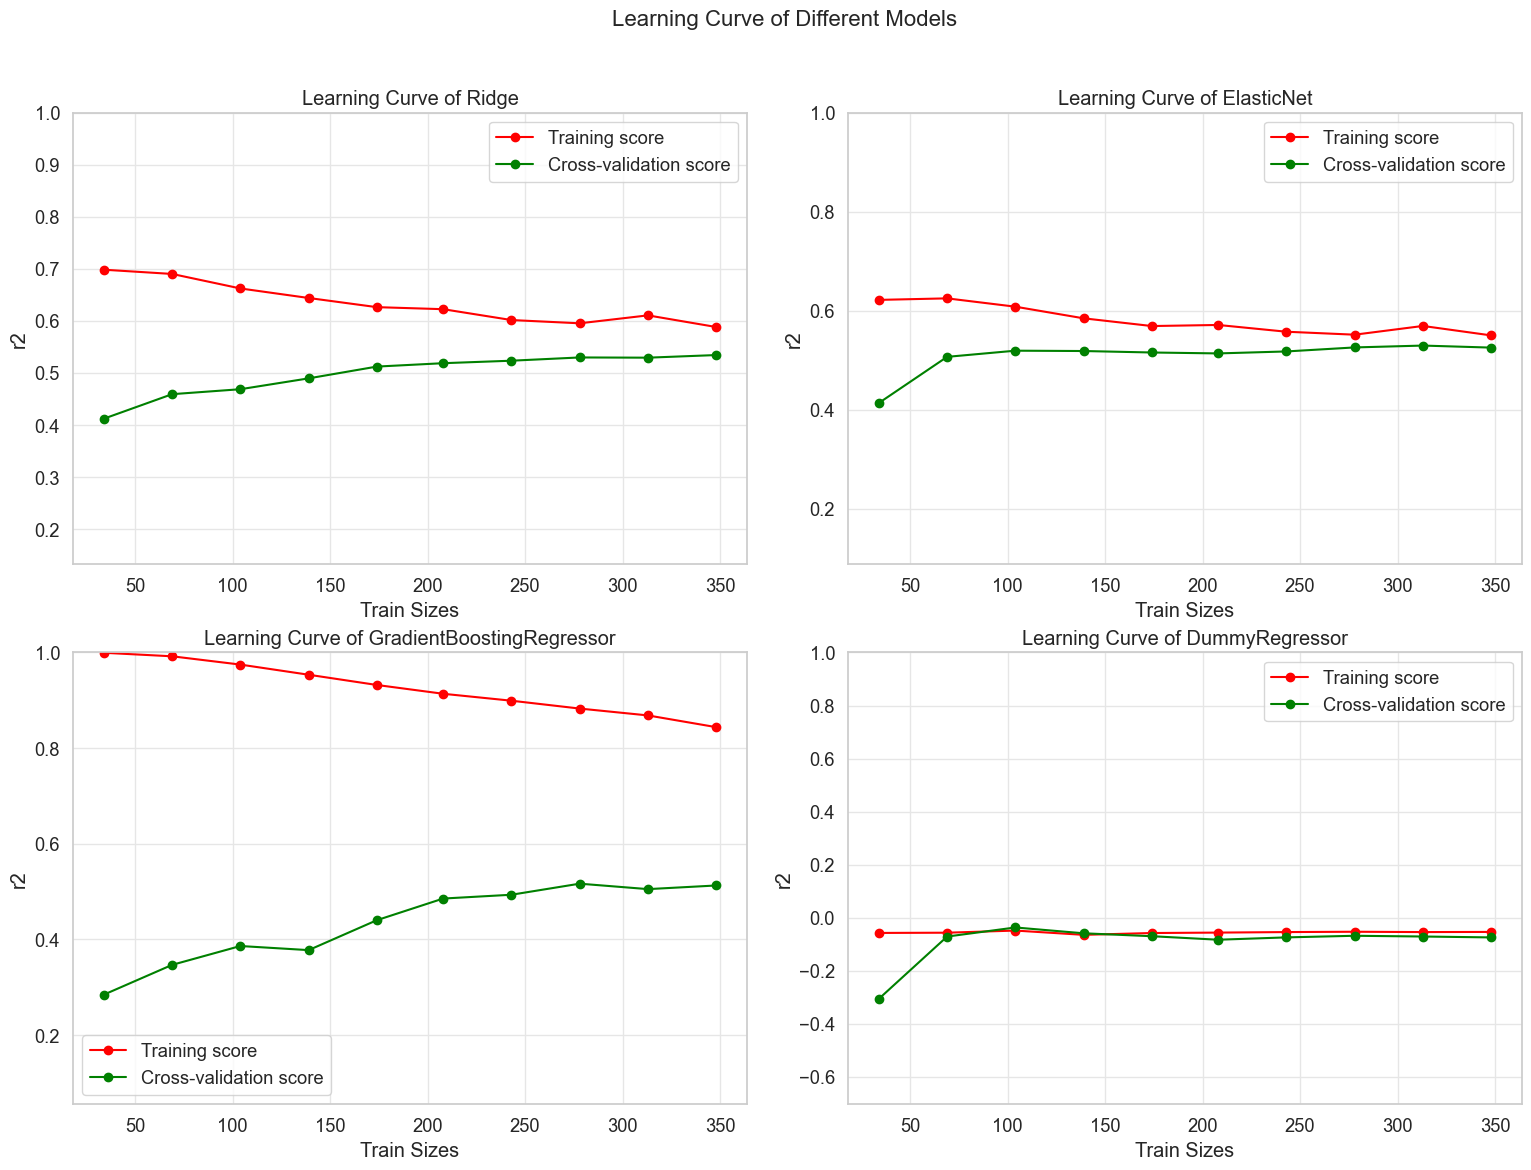

In [42]:
# Plot learning curve
fig, ax = plt.subplots(2, 2, figsize=(16, 12))

fig.suptitle("Learning Curve of Different Models", fontsize=16)

fig.tight_layout(pad=2.5)

# Ridge
plot_learning_curve(
    Ridge_reg,
    X_train,
    y_train,
    scoring='r2',
    ax=ax[0, 0],
)

# Ridge
plot_learning_curve(
    ElasticNet_reg,
    X_train,
    y_train,
    scoring='r2',
    ax=ax[0, 1],
)

# Gradient Boosting
plot_learning_curve(
    GB_reg,
    X_train,
    y_train,
    scoring='r2',
    ax=ax[1, 0],
)

# Dummy Classifier
plot_learning_curve(
    dummy_reg,
    X_train,
    y_train,
    scoring='r2',
    ax=ax[1, 1],
)

plt.show()

**Observations**:
- From the learning curve, it seems that DummyRegressor completely underfits with a negative r2 value
- All the other models seem to improve their Cross-Validation scores when there is a bigger train size
- The r2 scores of all three models are quite similar at around 0.5

## 5. Model Improvement

In order to try and improve the performance of our models, we can try to tune the hyperparameters of the model

In [43]:
print("Ridge Regressor: ")
print(list(Ridge().get_params().keys()))

Ridge Regressor: 
['alpha', 'copy_X', 'fit_intercept', 'max_iter', 'normalize', 'positive', 'random_state', 'solver', 'tol']


In [44]:
print("Elastic Net Regressor: ")
print(list(ElasticNet().get_params().keys()))

Elastic Net Regressor: 
['alpha', 'copy_X', 'fit_intercept', 'l1_ratio', 'max_iter', 'normalize', 'positive', 'precompute', 'random_state', 'selection', 'tol', 'warm_start']


In [45]:
print("Gradient Boosting Regressor: ")
print(list(GradientBoostingRegressor().get_params().keys()))

Gradient Boosting Regressor: 
['alpha', 'ccp_alpha', 'criterion', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_iter_no_change', 'random_state', 'subsample', 'tol', 'validation_fraction', 'verbose', 'warm_start']


**Hyperparameter Tuning and Evaluation**

We will be using GridSearchCV to run through the parameters and see which model's parameter will give the best recall

Hyperparameters to be tuned 
- Ridge:
  - alpha => constant that multiplies the L2 (ridge) term controlling regularization strength. When alpha=0, the model is the same as Linear Regression (no regularization)
  - solver => Solver to use in the computational routines
  - max_iter => maximum number of iterations for conjugate gradient solver

- ElasticNet:
  - alpha => constant that multiplies the penalty term
  - l1_ratio => ElasticNet mixing parameter l1_ratio = 1 is an L1 penalty, l1_ratio = 0 is an L2 penalty. For 0 < l1_ratio < 1, the penalty is a combination of l1 and l2
  - max_iter => maximum number of iterations for solver

- Gradient Boosting:
  - max_depth => Maximum depth of the individual regression estimators
  - n_estimators => number of boosting stages to perform
  - learning_rate => shrinks the contribution of each tree by a certain factor 
  - min_samples_leaf => minimum number of samples required to be at a leaf node (a split will only occur if the counr is fulfilled in each of the left and right branches)



In [46]:
# Tune Ridge
params_grid = {
    "alpha": [0.0001, 0.001, 0.01, 0.1, 1],
    "solver": ["auto", "svd", "cholesky", "lsqr", "sparse_cg", "sag", "saga"],
    "max_iter": [1000, 5000, 10000],
}

# Create model using pipeline
steps[model_step] = (
    "tuning",
    GridSearchCV(
        Ridge(),
        params_grid,
        cv=10,
        verbose=1,
        n_jobs=-1,
        scoring='r2',
    ),
)

Ridge_gridSearch = Pipeline(steps)

# Fit the model
Ridge_gridSearch.fit(X_train, y_train)

print(Ridge_gridSearch.named_steps["tuning"].best_estimator_)
print(Ridge_gridSearch.named_steps["tuning"].best_params_)
print(Ridge_gridSearch.named_steps["tuning"].best_score_)

Fitting 10 folds for each of 105 candidates, totalling 1050 fits


Ridge(alpha=1, max_iter=1000, solver='sparse_cg')
{'alpha': 1, 'max_iter': 1000, 'solver': 'sparse_cg'}
0.5110295191773223


In [47]:
# Tune elasticNet

params_grid = {
    "alpha": [0.0001, 0.001, 0.01, 0.1],
    "l1_ratio": np.linspace(0, 1, 10),
    "max_iter": [1000, 5000, 10000],
}

# Create model using pipeline
steps[model_step] = (
    "tuning",
    GridSearchCV(
        ElasticNet(),
        params_grid,
        cv=10,
        verbose=1,
        n_jobs=-1,
        scoring='r2',
    ),
)

ElasticNet_gridSearch = Pipeline(steps)

# Fit the model
ElasticNet_gridSearch.fit(X_train, y_train)

print(ElasticNet_gridSearch.named_steps["tuning"].best_estimator_)
print(ElasticNet_gridSearch.named_steps["tuning"].best_params_)
print(ElasticNet_gridSearch.named_steps["tuning"].best_score_)

Fitting 10 folds for each of 120 candidates, totalling 1200 fits
ElasticNet(alpha=0.1, l1_ratio=0.0)
{'alpha': 0.1, 'l1_ratio': 0.0, 'max_iter': 1000}
0.5112018912152501


c:\Users\ryany\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.028e+12, tolerance: 1.344e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


In [48]:
# Tune Gradient Boosting

params_grid = {
    "max_depth": [3, 5, 7],
    "n_estimators": [100, 500, 1000, 5000],
    "learning_rate": [0.001, 0.01, 0.1],
    "min_samples_leaf": [1, 3, 5],
}

# Create model using pipeline

steps[model_step] = (
    "tuning",
    GridSearchCV(
        GradientBoostingRegressor(),
        params_grid,
        cv=10,
        verbose=1,
        n_jobs=-1,
        scoring='r2',
    ),
)

GB_gridSearch = Pipeline(steps)

# Fit the model
GB_gridSearch.fit(X_train, y_train)

print(GB_gridSearch.named_steps["tuning"].best_estimator_)
print(GB_gridSearch.named_steps["tuning"].best_params_)
print(GB_gridSearch.named_steps["tuning"].best_score_)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


GradientBoostingRegressor(learning_rate=0.001, n_estimators=5000)
{'learning_rate': 0.001, 'max_depth': 3, 'min_samples_leaf': 1, 'n_estimators': 5000}
0.5308269306318968


**Model Evaluation**

We will now evaluate the model on an independent test set to see if the model can generalize well to unseen examples

In [49]:
print(y_test.shape)

(109,)


**Initiate model after hyperparameter tuning**

In [50]:
steps[model_step] = ("model", Ridge_gridSearch.named_steps["tuning"].best_estimator_)
tuned_Ridge_reg = Pipeline(steps)
# Fit the model
tuned_Ridge_reg.fit(X_train, y_train)
# Predict the values
Ridge_y_pred = tuned_Ridge_reg.predict(X_test)

In [51]:
steps[model_step] = ("model", ElasticNet_gridSearch.named_steps["tuning"].best_estimator_)
tuned_ElasticNet_reg = Pipeline(steps)
# Fit the model
tuned_ElasticNet_reg.fit(X_train, y_train)
# Predict the values
ElasticNet_y_pred = tuned_ElasticNet_reg.predict(X_test)

c:\Users\ryany\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.028e+12, tolerance: 1.344e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


In [52]:
steps[model_step] = ("model", GB_gridSearch.named_steps["tuning"].best_estimator_)
tuned_GB_reg = Pipeline(steps)
# Fit the model
tuned_GB_reg.fit(X_train, y_train)
# Predict the values
GB_y_pred = tuned_GB_reg.predict(X_test)

**Comparing the tuned models**

Now, the models will be compared using:
- Residual Plot
- Prediction Error Plot

**Residual Plot**

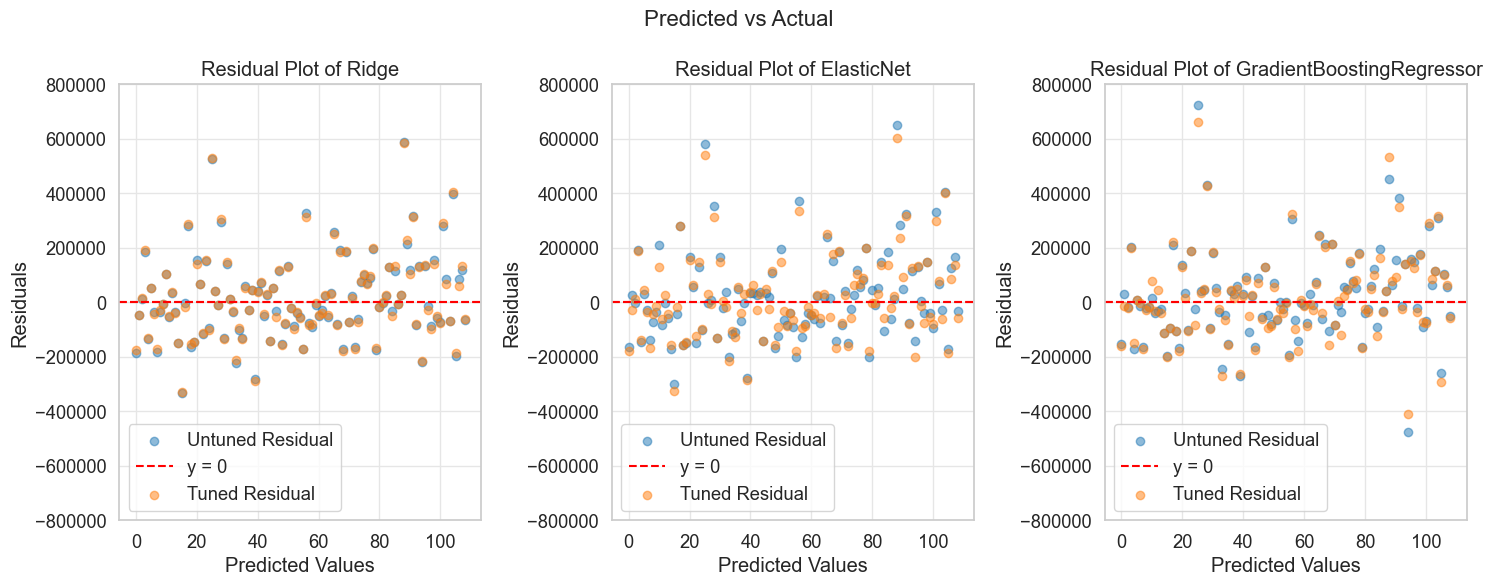

In [53]:
fig, ax = plt.subplots(1, 3, figsize=(15, 6))

fig.suptitle("Predicted vs Actual", fontsize=16)

# Untuned Ridge
plot_residuals(
    Ridge_reg,
    X_test,
    y_test,
    ax=ax[0]
)

# Tuned Ridge
plot_residuals(
    tuned_Ridge_reg,
    X_test,
    y_test,
    ax=ax[0]
)

# Set legend for the first plot
ax[0].legend(
    [
        "Untuned Residual",
        "y = 0",
        "Tuned Residual"
    ],
    loc="lower left",
)

# Untuned ElasticNet
plot_residuals(
    ElasticNet_reg,
    X_test,
    y_test,
    ax=ax[1]
)

# Tuned ElasticNet
plot_residuals(
    tuned_ElasticNet_reg,
    X_test,
    y_test,
    ax=ax[1]
)

# Set legend for the second plot
ax[1].legend(
    [
        "Untuned Residual",
        "y = 0",
        "Tuned Residual"
    ],
    loc="lower left",
)

# Untuned GB
plot_residuals(
    GB_reg,
    X_test,
    y_test,
    ax=ax[2]
)

# Tuned GB
plot_residuals(
    tuned_GB_reg,
    X_test,
    y_test,
    ax=ax[2]
)

# Set legend for the third plot
ax[2].legend(
    [
        "Untuned Residual",
        "y = 0",
        "Tuned Residual"
    ],
    loc="lower left",
)

# Set y-axis scale to be the same for all plots
ax[0].set_ylim(-800000, 800000)
ax[1].set_ylim(-800000, 800000)
ax[2].set_ylim(-800000, 800000)

plt.tight_layout()

plt.show()

**Observation**

Based on the residual plot, it seems that there is not much overlap between tuned and untuned residuals for ElasticNet but there is some noticeable overlap between the tuned and untuned residuals for Ridge and Gradient Boosting. This suggests that there is not much improvement after tuning for Ridge and Gradient Boosting but there is some noticeable improvement for ElasticNet.

Based on the residual plot, it seems that Ridge regression has the least extreme outliers (not exceeding 600 000) which might suggest that it might have performed slightly better compared to ElasticNet and Gradient Boosting

**Prediction Error Plot**

UNTUNED MODELS:

Ridge's R2: 0.528
ElasticNet's R2: 0.473
GradientBoostingRegressor's R2: 0.482

TUNED MODELS:

Ridge's R2: 0.529
ElasticNet's R2: 0.519
GradientBoostingRegressor's R2: 0.485


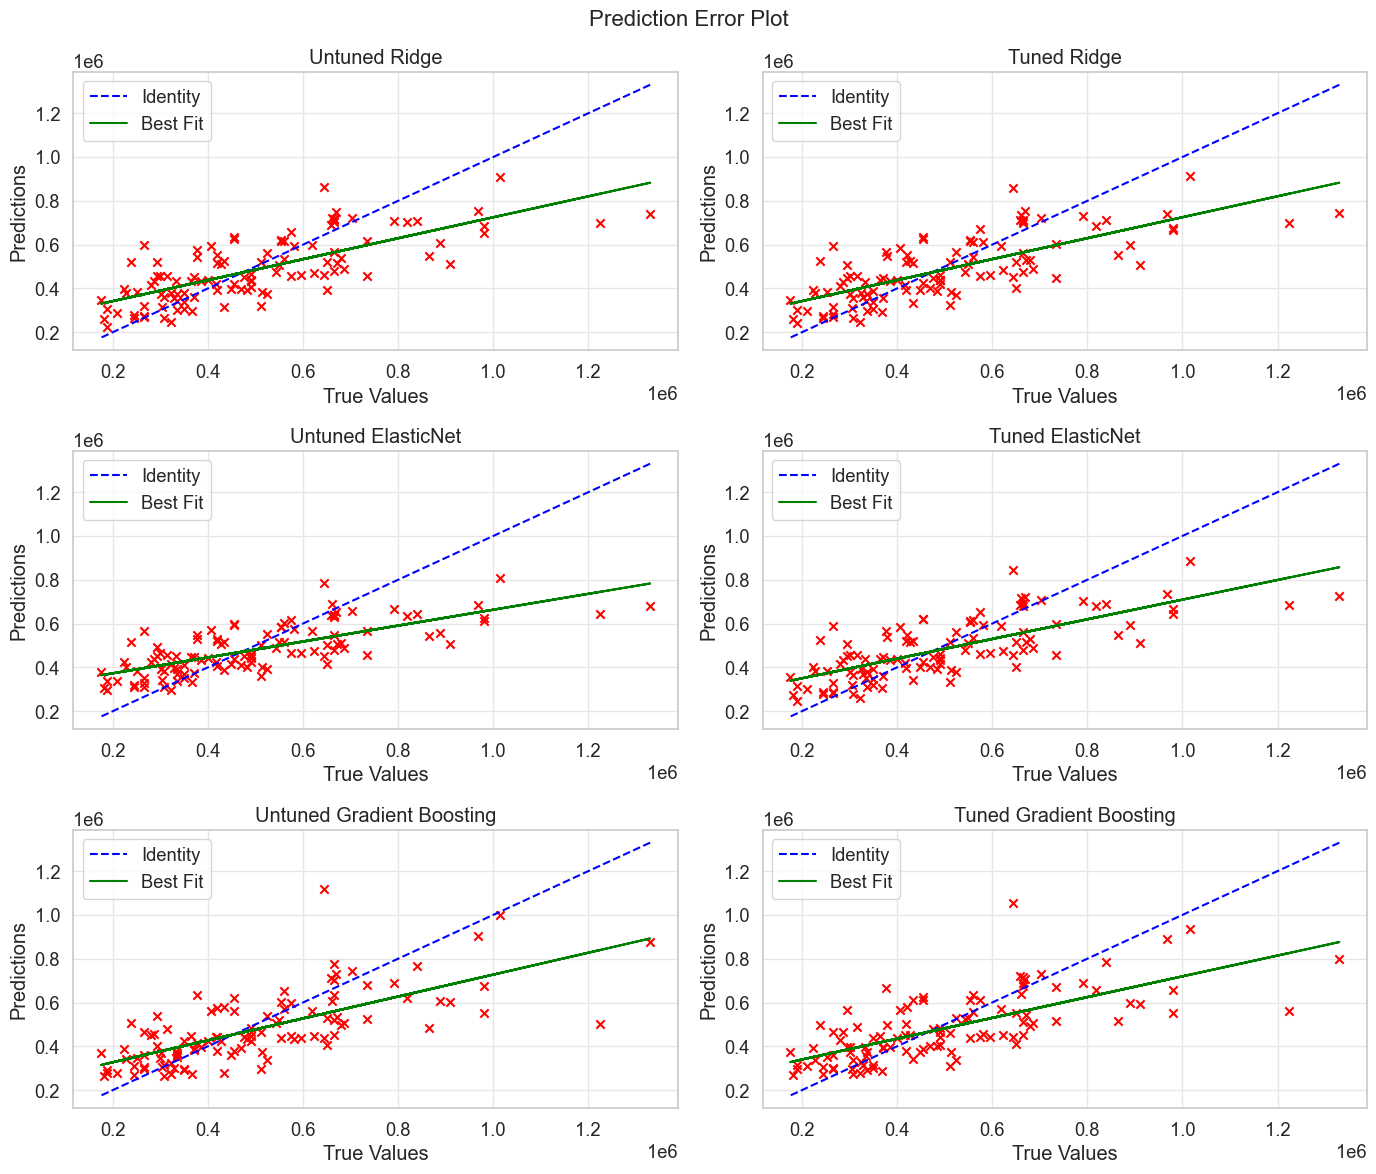

In [54]:
fig, ax = plt.subplots(3, 2, figsize=(14, 12))

fig.suptitle("Prediction Error Plot", fontsize=16)

print("UNTUNED MODELS:\n")
# Untuned Ridge
plot_prediction_error(
    Ridge_reg,
    X_test,
    y_test,
    ax=ax[0, 0]
)

# Untuned ElasticNet
plot_prediction_error(
    ElasticNet_reg,
    X_test,
    y_test,
    ax=ax[1, 0]
)

# Untuned GB
plot_prediction_error(
    GB_reg,
    X_test,
    y_test,
    ax=ax[2, 0]
)

print("\nTUNED MODELS:\n")

# Tuned Ridge
plot_prediction_error(
    tuned_Ridge_reg,
    X_test,
    y_test,
    ax=ax[0, 1]
)

# Tuned ElasticNet
plot_prediction_error(
    tuned_ElasticNet_reg,
    X_test,
    y_test,
    ax=ax[1, 1]
)

# Tuned GB
plot_prediction_error(
    tuned_GB_reg,
    X_test,
    y_test,
    ax=ax[2, 1]
)

# Overwrite title
ax[0, 0].set_title("Untuned Ridge")
ax[1, 0].set_title("Untuned ElasticNet")
ax[2, 0].set_title("Untuned Gradient Boosting")

ax[0, 1].set_title("Tuned Ridge")
ax[1, 1].set_title("Tuned ElasticNet")
ax[2, 1].set_title("Tuned Gradient Boosting")

plt.tight_layout()

plt.show()

**Observations**:

Based on the graphs, it seems that all the models have a moderate positive relationship between the features and the target variable. Judging solely based on the prediction error plot, it is hard to judge which models performed better.

From the R2 score, it shows that all tuned models have a slightly better performance compared to the untuned models with elasticNet having the greatest boost in performance. Overall, it seems that Ridge regression has the best performance with an R2 score of 0.529

In [55]:
pred_scores = pd.DataFrame(
    [
        [
            mean_squared_error(y_test, Ridge_y_pred, squared=False),
            mean_squared_error(y_test, ElasticNet_y_pred, squared=False),
            mean_squared_error(y_test, GB_y_pred, squared=False)
        ],
        [
            r2_score(y_test, Ridge_y_pred),
            r2_score(y_test, ElasticNet_y_pred),
            r2_score(y_test, GB_y_pred)
        ]
    ],
    index=["RMSE", "R2"],
    columns=["Ridge", "ElasticNet", "Gradient Boosting"]
)

display(pred_scores)


,Ridge,ElasticNet,Gradient Boosting
RMSE,154308.594854,155943.075786,161287.625471
R2,0.528919,0.518886,0.485343


**Feature Importance**

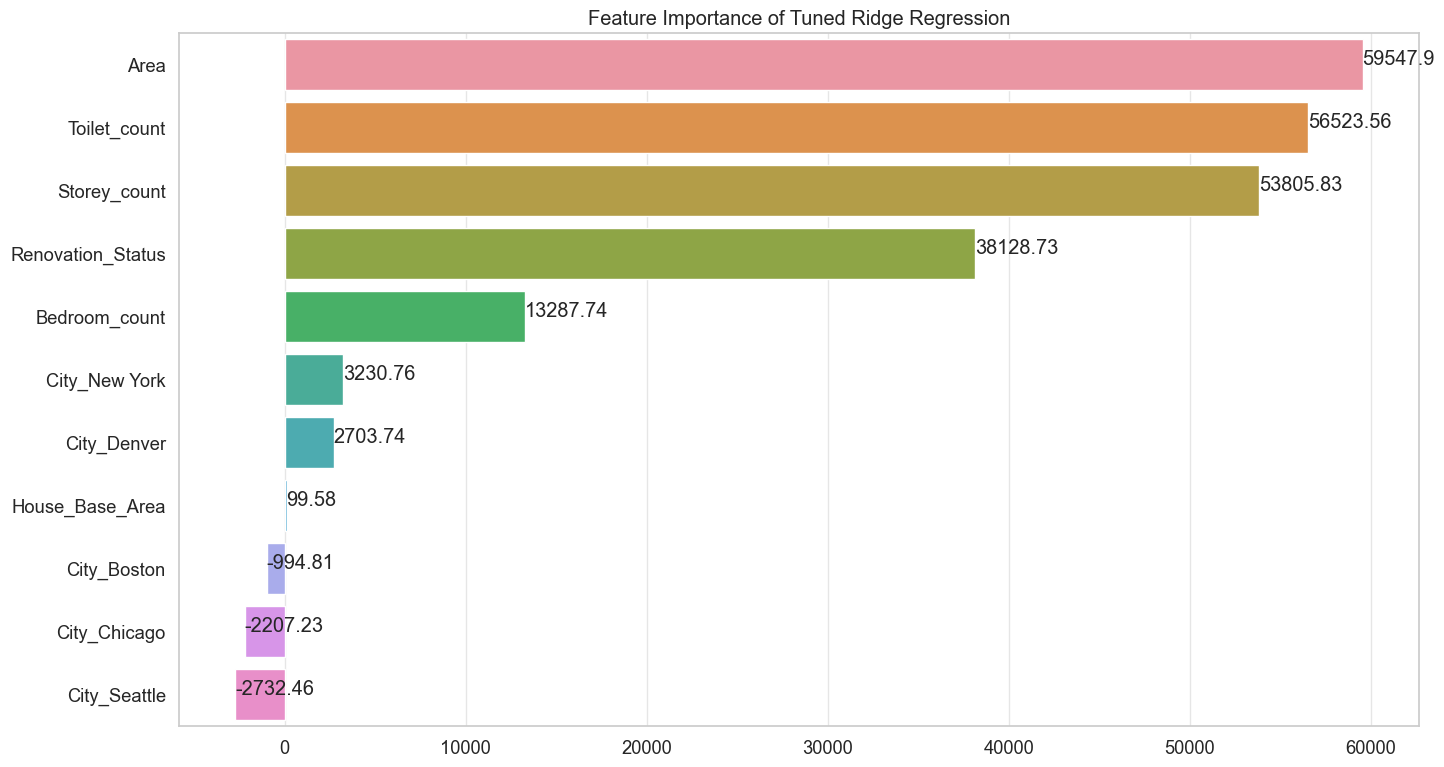

In [56]:
# Show the feature importance for Ridge

# Get coefficient of tuned Ridge
importance = tuned_Ridge_reg.named_steps["model"].coef_
# Get the feature names
feature_names = ['City_Boston','City_Chicago','City_Denver','City_New York','City_Seattle','Renovation_Status','Area', 'Bedroom_count', 'Toilet_count', 'Storey_count', 'House_Base_Area']

# Convert to dataframe
importance_series = pd.Series(importance, index=feature_names).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(16, 9))
sns.barplot(
    x=importance_series, y=importance_series.index, ax=ax
)
ax.set_title("Feature Importance of Tuned Ridge Regression")
# Set text labels
[ax.text(x=val, y=idx, s=round(val, 2)) for idx, val in zip(np.arange(0,len(importance_series)), importance_series.values)]

plt.show()


**Observations**:
- From the feature importance, it seems that Area is the most important feature in predicting housing prices which makes sense since the size of the house is one of the first few thing people consider
- Other factors that seem to be positively correlated with price are number of toilets, number of storeys in the house and the renovation status of the hosue
- Houses that are located in either Boston, Chicago or Seattle seem to have a negative correlation with prices while houses that are located in either New York or denver seem to have a positive correlation with price

**Saving the models**

In [57]:
import os

# Create a folder for the models if it does not exist
if not os.path.exists("models"):
    os.makedirs("models")

#  Save all three models as pickle files
pickle.dump(tuned_Ridge_reg, open("models/tuned_Ridge_reg.pkl", "wb"))
pickle.dump(tuned_ElasticNet_reg, open("models/tuned_ElasticNet_reg.pkl", "wb"))
pickle.dump(tuned_GB_reg, open("models/tuned_GB_reg.pkl", "wb"))